# Eval runs

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from pathlib import Path
import ast
import seaborn as sns

pd.set_option('display.max_columns', None)

In [14]:
def read_metrics_file(file_path):
    df = pd.read_csv(file_path, sep=" ", header=None, names=["Timestamp", "Value", "Label"])[["Value"]].iloc[-1]
    return df

def read_config_file(file_path):
    """
    Read configuration settings from a config.txt file.
    """
    with open(file_path, 'r') as file:
        txt = file.read().replace("device(type='cuda', index=0)", "0")
        config = ast.literal_eval(txt)
    return config

def read_metrics_and_config_from_directory(directory_root):
    """
    Read metrics from all files in a directory and its subdirectories recursively.
    """
    
    run_data = {}
    runs_path = Path(directory_root)
    # Iterate over all runs
    for run_dir in runs_path.glob('**/metrics'):
        metric_data = {}
        for metric_file in run_dir.iterdir():
            metric_data[metric_file.stem] = read_metrics_file(metric_file)
        
        if len(metric_data) == 0:
            print(metric_data)
            print(run_dir)
        combined_df = pd.concat(metric_data, axis=1)
        run_data[(run_dir.parent.parent.name, run_dir.parent.name)] = combined_df

    run_configs = {}
    # Iterate over all runs
    for run_dir in runs_path.glob('**/params'):
        for metric_file in run_dir.iterdir():
            config = read_config_file(metric_file)
        run_configs[(run_dir.parent.parent.name, run_dir.parent.name)] = config

    return run_data, run_configs

def load_dataframe(directory):
    # Read metrics from all files in the directory
    run_data, run_configs = read_metrics_and_config_from_directory(directory)

    modified_dfs = []
    for key, df in run_data.items():
        df['ml_run_experiment'] = key[0]
        df['ml_run_id'] = key[1]
        df['ml_run_name'] = run_configs[key]['RUN_NAME']
        modified_dfs.append(df)
    df_runs = pd.concat(modified_dfs, axis=0, ignore_index=True)
     
    return df_runs, run_configs

# Define the directory containing metric files
directory = 'C:\\Users\\Eduard\\PycharmProjects\\HM_IDENT_3DFR\\log\\mlruns'
df_runs, run_configs = load_dataframe(directory)
print(df_runs.shape, len(run_configs.items()))
df_runs.head(5)

(113, 33) 113


bellus_inter_enrolled_center_avg_distance  \
0                                   1.022477   
1                                   1.022419   
2                                   1.022472   
3                                   1.022224   
4                                   1.022320   

   bellus_intra_enrolled_avg_distance  bellus_intra_query_avg_distance  \
0                            2.288499                        14.094703   
1                            2.269657                        13.970072   
2                            2.288730                        13.954801   
3                            9.689315                        41.689744   
4                            9.733482                        42.269732   

   bellus_intra_scan_avg_distance  bellus_RR1  bellus_RR5  bellus_Voting_RR1  \
0                        2.439353       98.89      100.00             100.00   
1                        2.411802       99.58       99.97             100.00   
2                        2.409020       99.37      100.00             100.00   
3                        9.662425       70.85       81.84              93.91   
4                        9.766006       66.33       77.22              93.04   

   bellus_Voting_RR5  facescape_inter_enrolled_center_avg_distance  \
0             100.00                                      0.998439   
1             100.00                                      0.998027   
2             100.00                                      0.998137   
3              93.91                                      1.001637   
4              93.04                                      1.001489   

   facescape_intra_enrolled_avg_distance  facescape_intra_query_avg_distance  \
0                               7.148080                          122.954876   
1                               6.847860                          117.889257   
2                               6.867062                          118.210704   
3                              12.634703                          210.800066   
4                              12.746241                          213.418203   

   facescape_intra_scan_avg_distance  facescape_RR1  facescape_RR5  \
0                           6.096929          37.05          63.90   
1                           5.848868          36.33          63.15   
2                           5.870434          38.49          65.65   
3                          10.566850          36.93          49.49   
4                          10.698474          33.85          45.41   

   facescape_Voting_RR1  facescape_Voting_RR5  \
0                 84.33                 84.33   
1                 84.07                 84.07   
2                 86.83                 86.83   
3                 67.83                 67.83   
4                 54.08                 54.08   

   faceverse_inter_enrolled_center_avg_distance  \
0                                      1.003976   
1                                      1.004312   
2                                      1.005068   
3                                      1.007046   
4                                      1.007066   

   faceverse_intra_enrolled_avg_distance  faceverse_intra_query_avg_distance  \
0                               5.873115                          141.753108   
1                               5.771780                          139.305295   
2                               5.635120                          139.399438   
3                              10.733993                          225.217102   
4                              10.980495                          230.556700   

   faceverse_intra_scan_avg_distance  faceverse_RR1  faceverse_RR5  \
0                           6.076742          47.38          72.16   
1                           5.969512          47.90          72.76   
2                           5.901474          47.55          72.13   
3                          10.749569          41.54          57.65   
4                          11.01

In [15]:
#def translate_mlflow_to_experiment_name(run_configs, mlflow_run_experiment_ids, ml_run_ids):
#    x_ticks = []
#    for e,i in zip(mlflow_run_experiment_ids, ml_run_ids):
#        x_ticks.append(run_configs[(e,i)]['RUN_NAME'])
#    
#    unique_list = []
#    [unique_list.append(x) for x in x_ticks if x not in unique_list]
#    return unique_list

def plot_bar(df, rotation=45, figsize=(10, 10), voting = True, color_list=['skyblue', 'orange', 'lightgreen','red']) :# bar_columns, labels, title_suffix, color_list, rotation=45, annotate=True):

    ml_run_name = df['ml_run_name']
    xticks = []
    [xticks.append(x) for x in ml_run_name if x not in xticks]

    indices = np.arange(len(xticks))
    if voting:
        test_columns = ['bellus_Voting_RR1', 'facescape_Voting_RR1', 'faceverse_Voting_RR1', 'texas_Voting_RR1']
    else:
        test_columns = ['bellus_RR1', 'facescape_RR1', 'faceverse_RR1', 'texas_RR1']

    df_melted = pd.melt(df, id_vars=['ml_run_experiment'], value_vars=test_columns, 
                    var_name='Measure', value_name='Value')

    plt.figure(figsize=figsize)
    ax = sns.barplot(data=df_melted, x='ml_run_experiment', y='Value', hue='Measure', errorbar=('ci', 95), capsize=0.1, palette=color_list)

    # Add average values as text to the bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge")

    # Add horizontal lines for the rr_5 accuracies
    #top5_columns = ['bellus_RR5', 'facescape_RR5', 'faceverse_RR5', 'texas_RR5']
    #unique_experiments = df['ml_run_experiment'].unique()
    #width = 0.8 / len(unique_experiments)
    #for i, col in enumerate(top5_columns):
    #    for j, (experiment, value) in enumerate(zip(df['ml_run_experiment'], df[col])):
    ##        # Correct indexing for line positions
    #        x_position = j - width/2 + i*width + width/2
    #        plt.hlines(y=value, xmin=x_position - width/2, xmax=x_position + width/2, 
    #                colors=color_list[i], linestyles='dashed')
    #        plt.text(x_position, value, f'{value:.2f}', 
    #                ha='center', va='bottom', color=color_list[i])
    plt.xlabel('Experiment')
    plt.ylabel('Accuracy')
    plt.xticks(indices, xticks, rotation=rotation, ha='right')
    plt.tight_layout()

def analyse_embedding(df):
    plot_scatter_with_correlation_line(df['bellus_RR1'], df['bellus_inter_enrolled_center_avg_distance'], df['ml_run_experiment'], 'bellusRR1', 'bellus_inter_enrolled_center_avg_distance')
    plot_scatter_with_correlation_line(df['facescape_RR1'], df['facescape_inter_enrolled_center_avg_distance'], df['ml_run_experiment'], 'facescapeRR1', 'facescape_inter_enrolled_center_avg_distance')
    plot_scatter_with_correlation_line(df['bellus_RR1'], df['bellus_intra_enrolled_avg_distance'], df['ml_run_experiment'], 'bellusRR1', 'bellus_intra_enrolled_avg_distance')
    plot_scatter_with_correlation_line(df['facescape_RR1'], df['facescape_intra_enrolled_avg_distance'], df['ml_run_experiment'], 'facescapeRR1', 'facescape_intra_enrolled_avg_distance')
    plot_scatter_with_correlation_line(df['bellus_RR1'], df['bellus_intra_query_avg_distance'], df['ml_run_experiment'], 'bellusRR1', 'bellus_intra_query_avg_distance')
    plot_scatter_with_correlation_line(df['facescape_RR1'], df['facescape_intra_query_avg_distance'], df['ml_run_experiment'], 'facescapeRR1', 'facescape_intra_query_avg_distance')
    plot_scatter_with_correlation_line(df['bellus_RR1'], df['bellus_intra_scan_avg_distance'], df['ml_run_experiment'], 'bellusRR1', 'bellus_intra_scan_avg_distance')
    plot_scatter_with_correlation_line(df['facescape_RR1'], df['facescape_intra_scan_avg_distance'], df['ml_run_experiment'], 'facescapeRR1', 'facescape_intra_scan_avg_distance')
    plt.show()


# Function to plot a scatterplot with correlation line
def plot_scatter_with_correlation_line(x, y, labels, xlabel, ylabel):
    plt.figure(figsize=(7, 7))
    coefficients = np.polyfit(x, y, 1)
    poly = np.poly1d(coefficients)
    val_linspace = np.linspace(min(x), max(x), len(x))
    plt.scatter(x, y, color='green')
    plt.plot(val_linspace, poly(val_linspace), color='blue', linestyle='dashed', linewidth=2)
    for i, label in enumerate(labels):
        plt.text(x.iloc[i], y.iloc[i], label, fontsize=9, ha='right')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    correlation_coefficient, _ = pearsonr(x, y)
    print(f"Correlation coefficient: {correlation_coefficient:.3f}")
    
    
def analyze_accuracies(df, run_configs, voting):
    #xticks = translate_mlflow_to_experiment_name(run_configs, df['ml_run_experiment'], df['ml_run_id'])
    plot_bar(df, voting=voting)
    plt.show()

def select_runs(df, run_configs, rules):

    valid_keys = []
    for k,v in run_configs.items():
        accept = False
        for i in rules:
            if i in v['RUN_NAME']:
                accept = True
                break
        if accept:
            valid_keys.append(k[0])

    print('Selected:', len(valid_keys), valid_keys)

    filtered_df = df[df['ml_run_experiment'].isin(valid_keys)].copy()
    assert filtered_df.shape[0] == len(valid_keys)

    filtered_df['exp_id'] = filtered_df['ml_run_name'].str.extract(r'EXP(\d+)', expand=False).astype(int)
    filtered_df = filtered_df.sort_values('exp_id')
    return filtered_df



### EXP [1-6] rgb_bellus-45T_25P-enc_512-ArcFace-FocalLoss-112_112-batchsize_32-epochs50-\<MODEL\>

Selected: 18 ['222100124645481631', '222100124645481631', '222100124645481631', '363882690831110193', '363882690831110193', '363882690831110193', '415785875395131241', '415785875395131241', '415785875395131241', '491028380339639148', '491028380339639148', '491028380339639148', '748894875499767044', '748894875499767044', '748894875499767044', '891246952177035504', '891246952177035504', '891246952177035504']


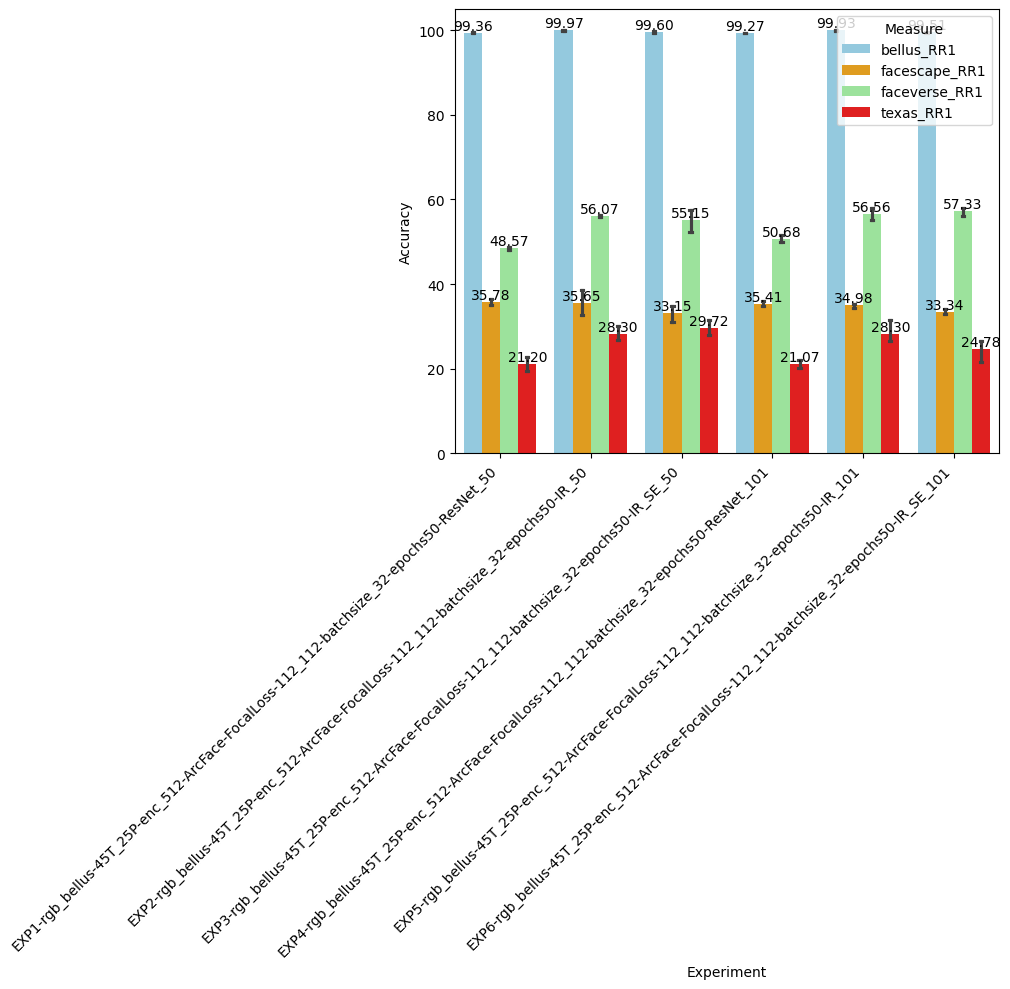

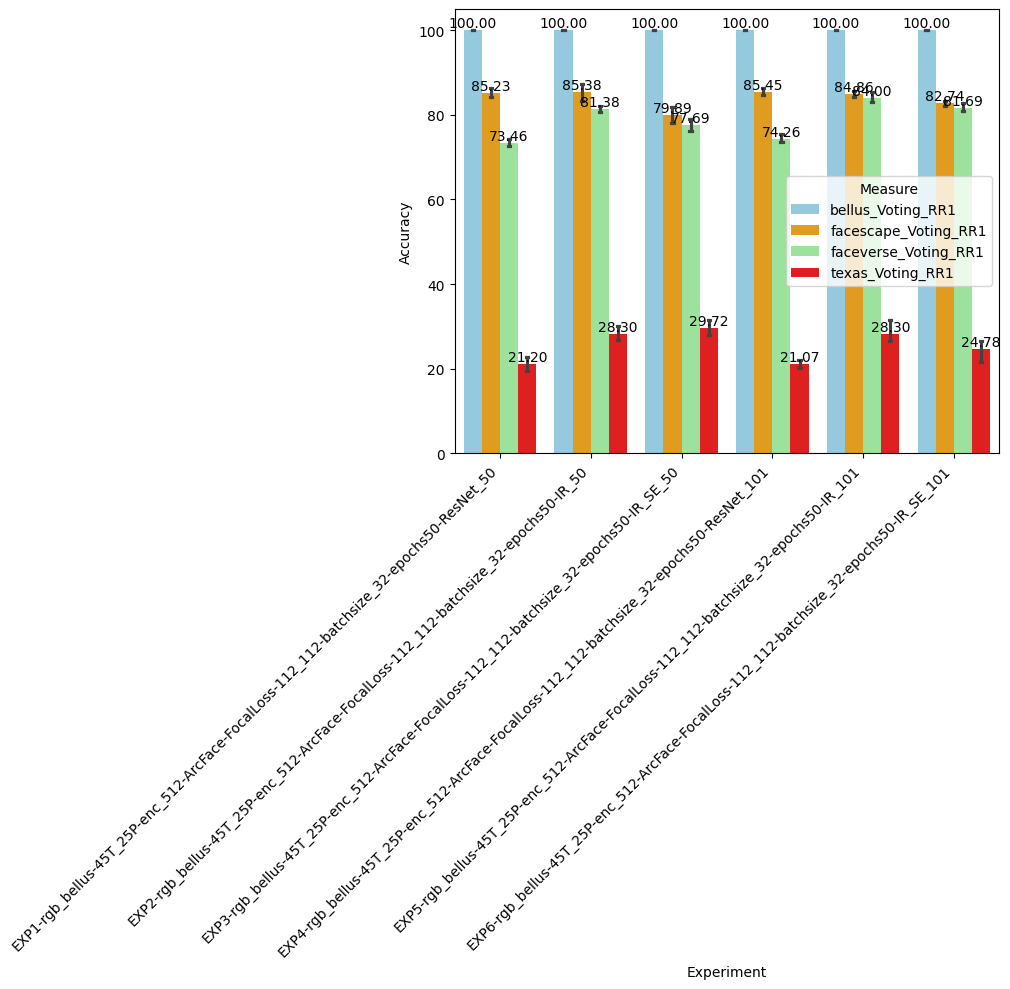

In [16]:
df_runs, run_configs = load_dataframe(directory)
df_selected = select_runs(df_runs, run_configs, ['EXP1-','EXP2-','EXP3-','EXP4-','EXP5-','EXP6-'])
analyze_accuracies(df_selected, run_configs, voting=False)
analyze_accuracies(df_selected, run_configs, voting=True)
#analyse_embedding(df_selected)

### EXP [7-12] depth_bellus-45T_25P-enc_512-ArcFace-FocalLoss-112_112-batchsize_32-epochs50-\<MODEL\>

Selected: 17 ['345097637784570927', '345097637784570927', '345097637784570927', '475567269307092217', '475567269307092217', '475567269307092217', '498748654963359631', '498748654963359631', '498748654963359631', '761951322906666558', '761951322906666558', '828788881478631883', '828788881478631883', '828788881478631883', '926074714150533979', '926074714150533979', '926074714150533979']


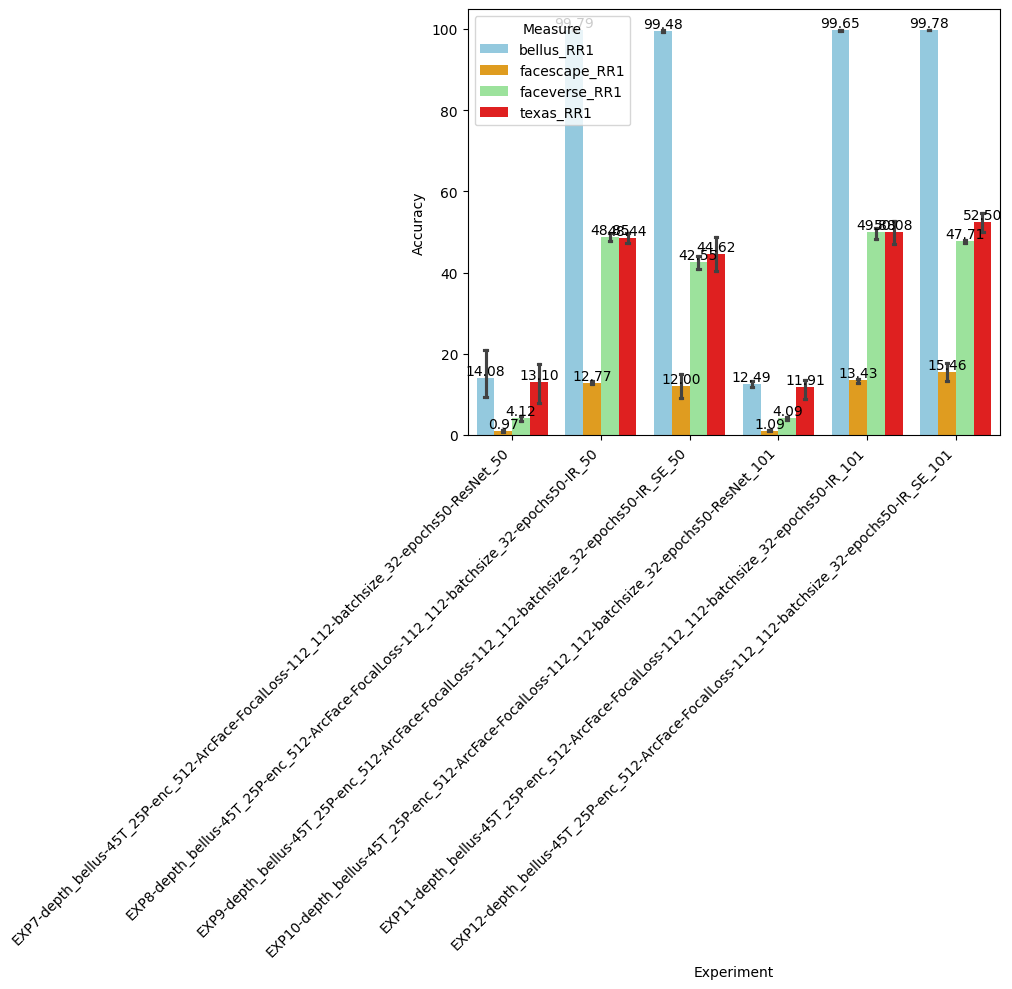

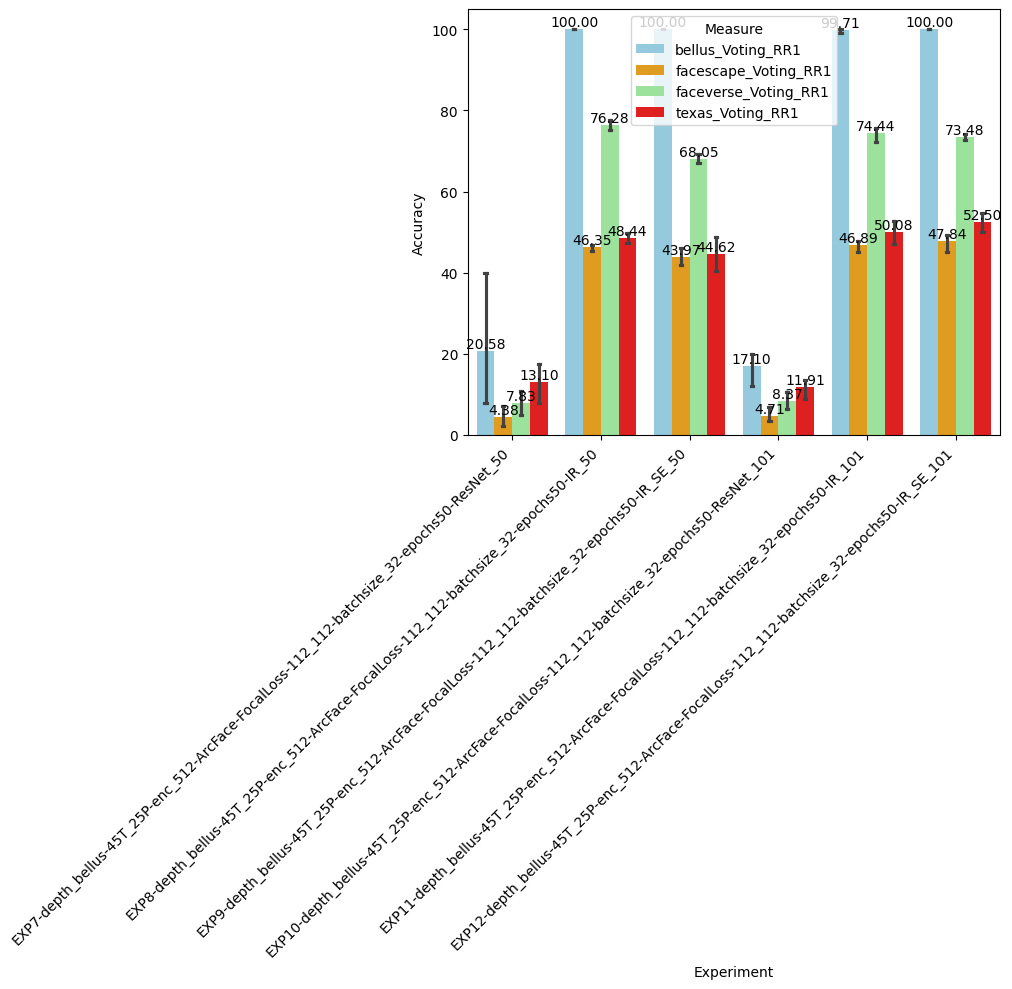

In [17]:
df_runs, run_configs = load_dataframe(directory)
df_selected = select_runs(df_runs, run_configs, ['EXP7-','EXP8-','EXP9-','EXP10-','EXP11-','EXP12-'])
analyze_accuracies(df_selected, run_configs, voting=False)
analyze_accuracies(df_selected, run_configs, voting=True)
#analyse_embedding(df_selected)

### EXP [13-18] rgbd_bellus-45T_25P-enc_512-ArcFace-FocalLoss-112_112-batchsize_32-epochs50-\<MODEL\>

Selected: 18 ['113129204246726823', '113129204246726823', '113129204246726823', '684526817602124812', '684526817602124812', '684526817602124812', '898263092529228606', '898263092529228606', '898263092529228606', '968146518580656468', '968146518580656468', '968146518580656468', '990636790004825293', '990636790004825293', '990636790004825293', '992720557218550828', '992720557218550828', '992720557218550828']


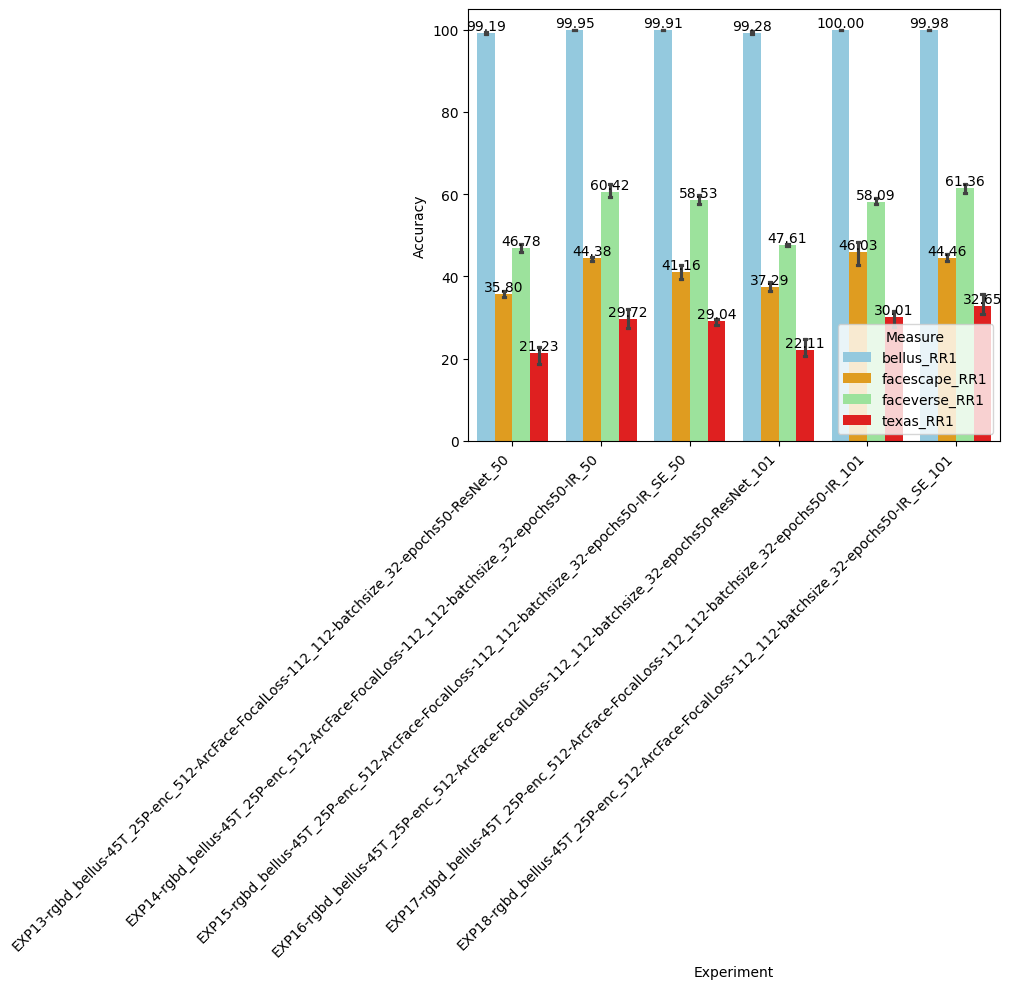

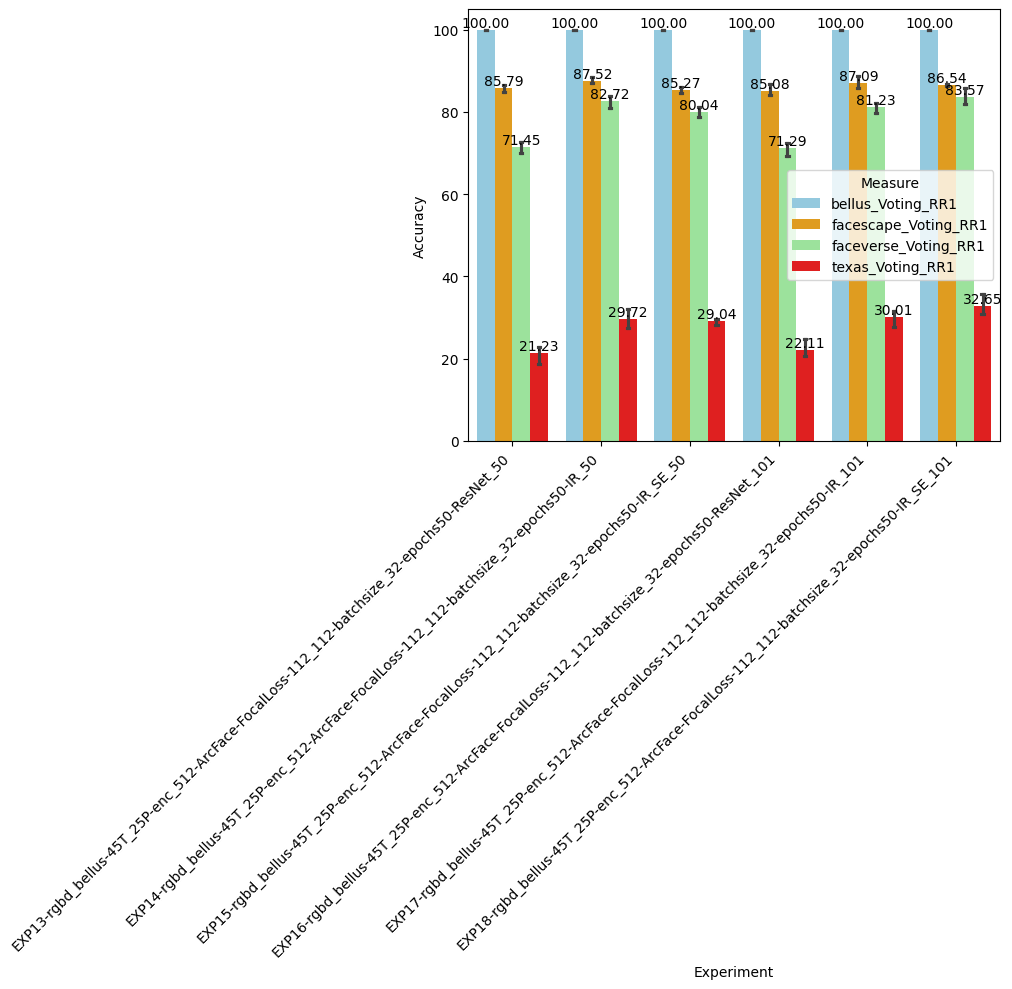

In [18]:
df_runs, run_configs = load_dataframe(directory)
df_selected = select_runs(df_runs, run_configs, ['EXP13-','EXP14-','EXP15-','EXP16-','EXP17-','EXP18-'])
analyze_accuracies(df_selected, run_configs, voting=False)
analyze_accuracies(df_selected, run_configs, voting=True)
#analyse_embedding(df_selected)

### EXP [19-24] rgbd_bellus-45T_25P-enc_512-ArcFace-FocalLoss-112_112-batchsize_[16/32]-epochs50-\<MODEL\>

Selected: 35 ['113129204246726823', '113129204246726823', '113129204246726823', '198001218989780979', '198001218989780979', '198001218989780979', '326301526227812475', '326301526227812475', '326301526227812475', '449428032172154329', '449428032172154329', '565141924842480235', '565141924842480235', '565141924842480235', '684526817602124812', '684526817602124812', '684526817602124812', '718201582151568174', '718201582151568174', '718201582151568174', '898263092529228606', '898263092529228606', '898263092529228606', '925354295638808217', '925354295638808217', '925354295638808217', '968146518580656468', '968146518580656468', '968146518580656468', '990636790004825293', '990636790004825293', '990636790004825293', '992720557218550828', '992720557218550828', '992720557218550828']


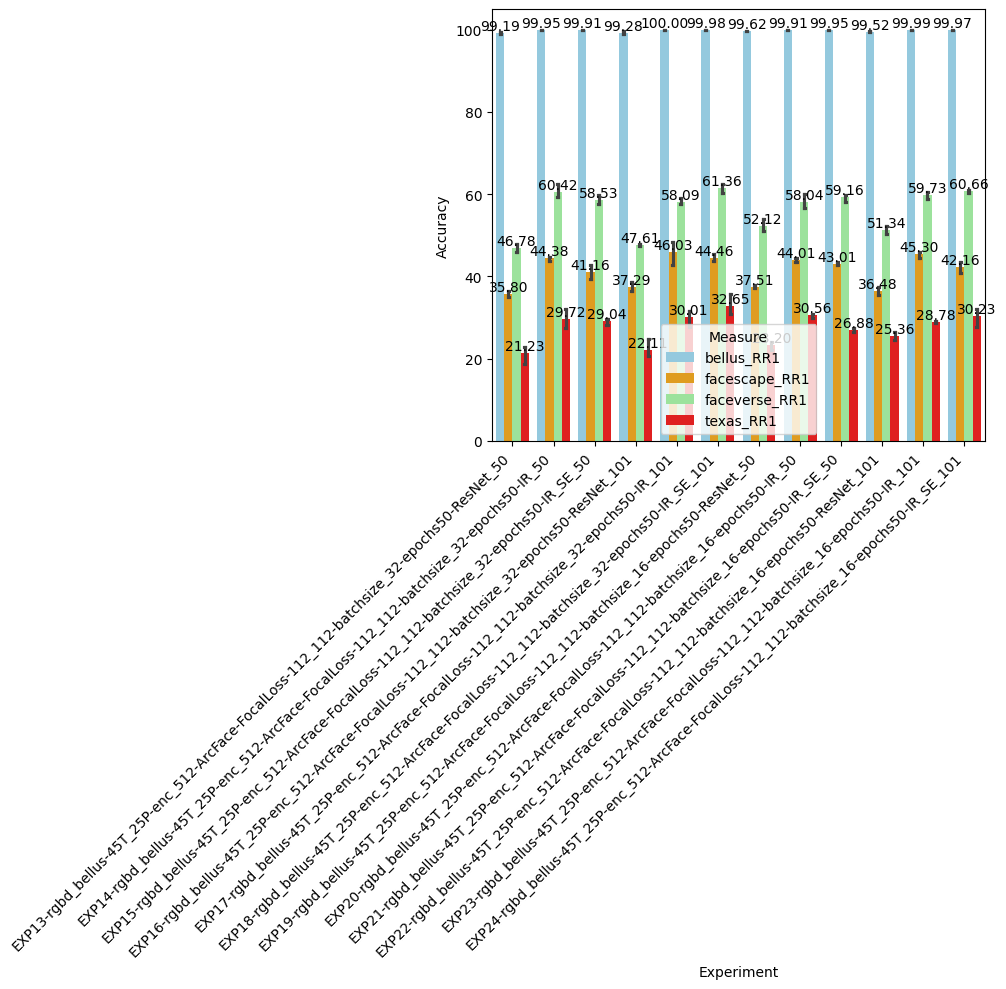

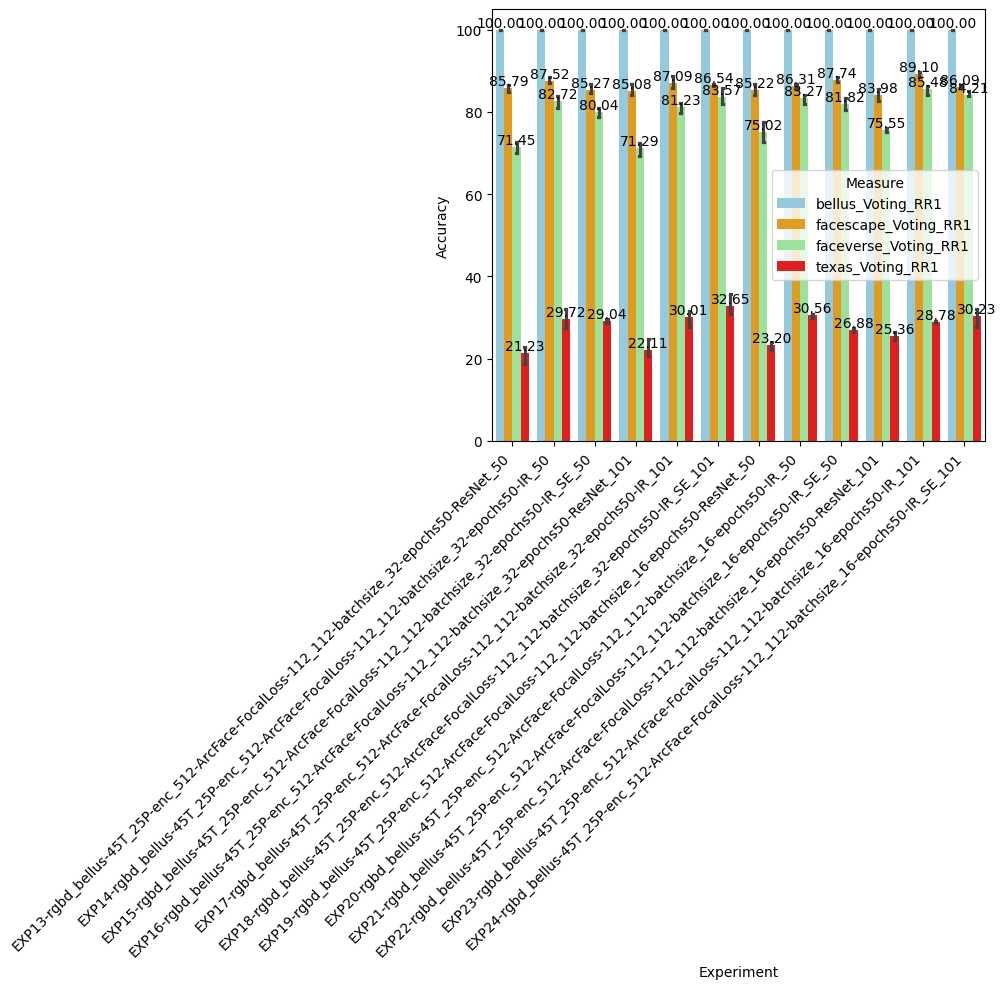

In [19]:
df_runs, run_configs = load_dataframe(directory)
df_selected = select_runs(df_runs, run_configs, ['EXP13-','EXP14-','EXP15-','EXP16-','EXP17-','EXP18-', 'EXP19-','EXP20-','EXP21-','EXP22-','EXP23-','EXP24-'])
analyze_accuracies(df_selected, run_configs, voting=False)
analyze_accuracies(df_selected, run_configs, voting=True)

### EXP [25-30] rgbd_facescape-500T_25P-enc_512-ArcFace-FocalLoss-112_112-batchsize_16-epochs50-\<MODEL\>

Selected: 7 ['412072104339477621', '412072104339477621', '412072104339477621', '658051556357491206', '670741189408236172', '670741189408236172', '888135547068834241']


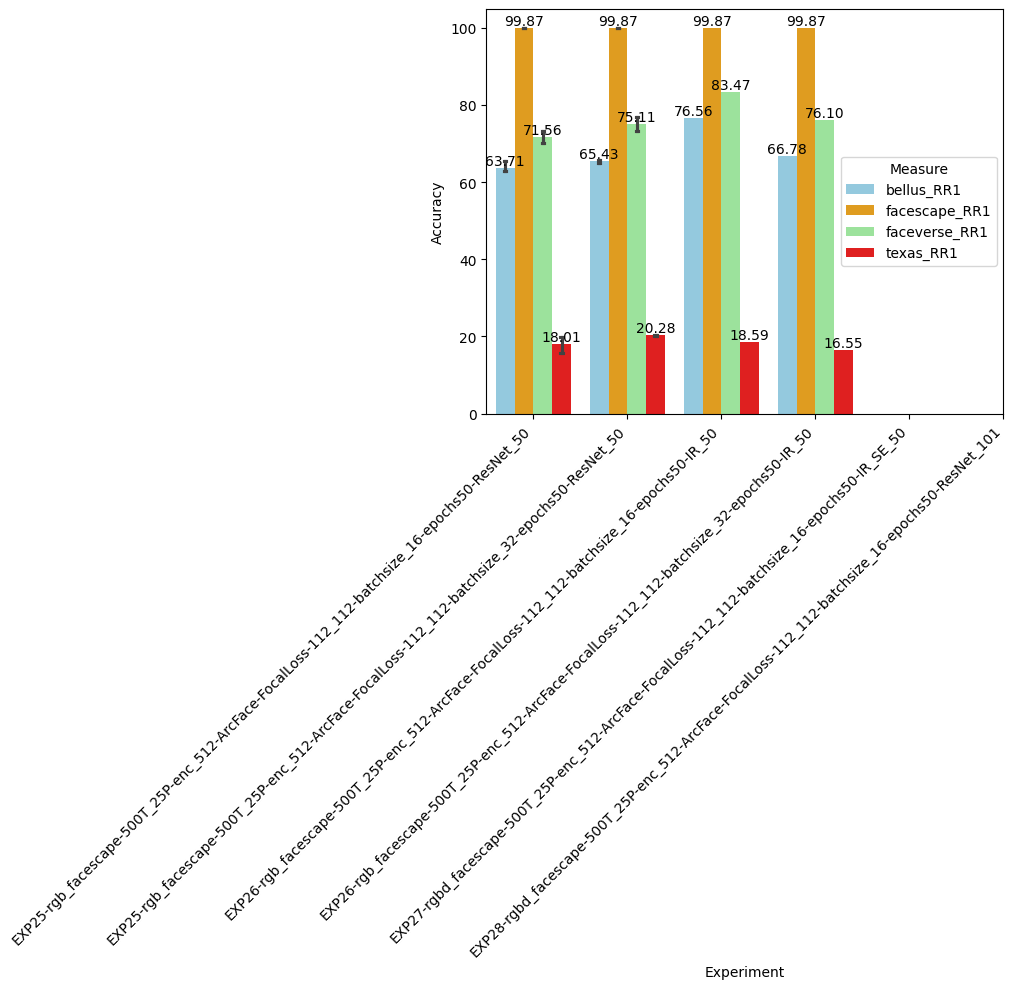

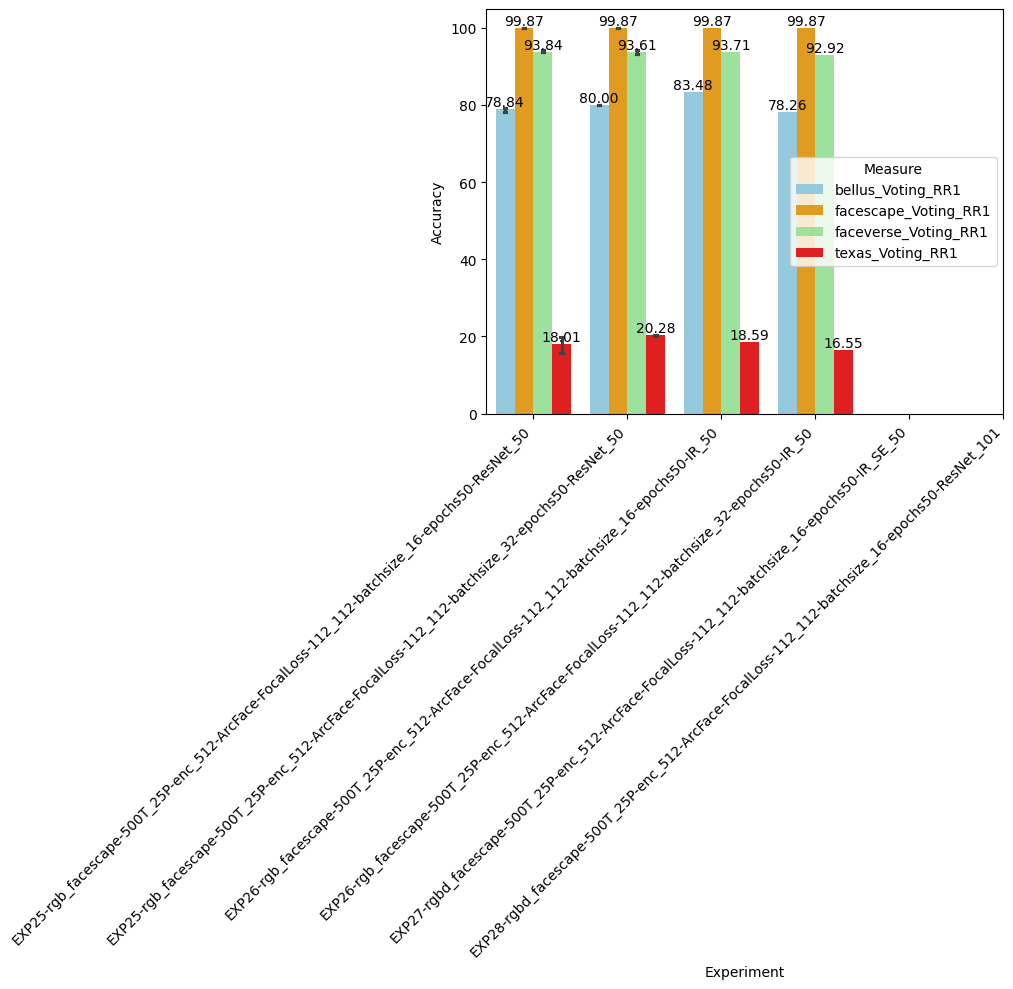

In [20]:
df_runs, run_configs = load_dataframe(directory)
df_selected = select_runs(df_runs, run_configs, ['EXP25-','EXP26-','EXP27-','EXP28-','EXP29-','EXP30-'])
analyze_accuracies(df_selected, run_configs, voting=False)
analyze_accuracies(df_selected, run_configs, voting=True)

### EXP [31-36] depth_facescape-500T_25P-enc_512-ArcFace-FocalLoss-112_112-batchsize_16-epochs50-\<MODEL\>

Selected: 3 ['221021306140145340', '254565957053446777', '746262022341731760']


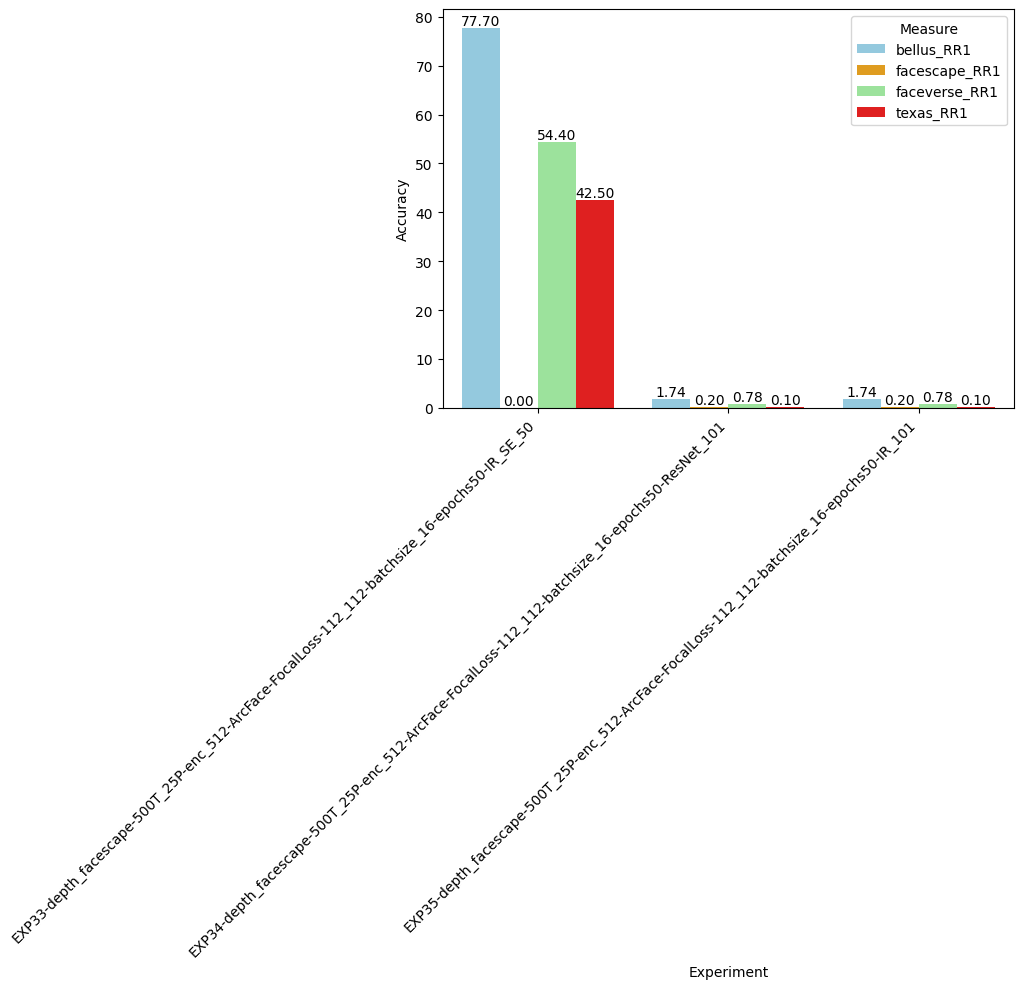

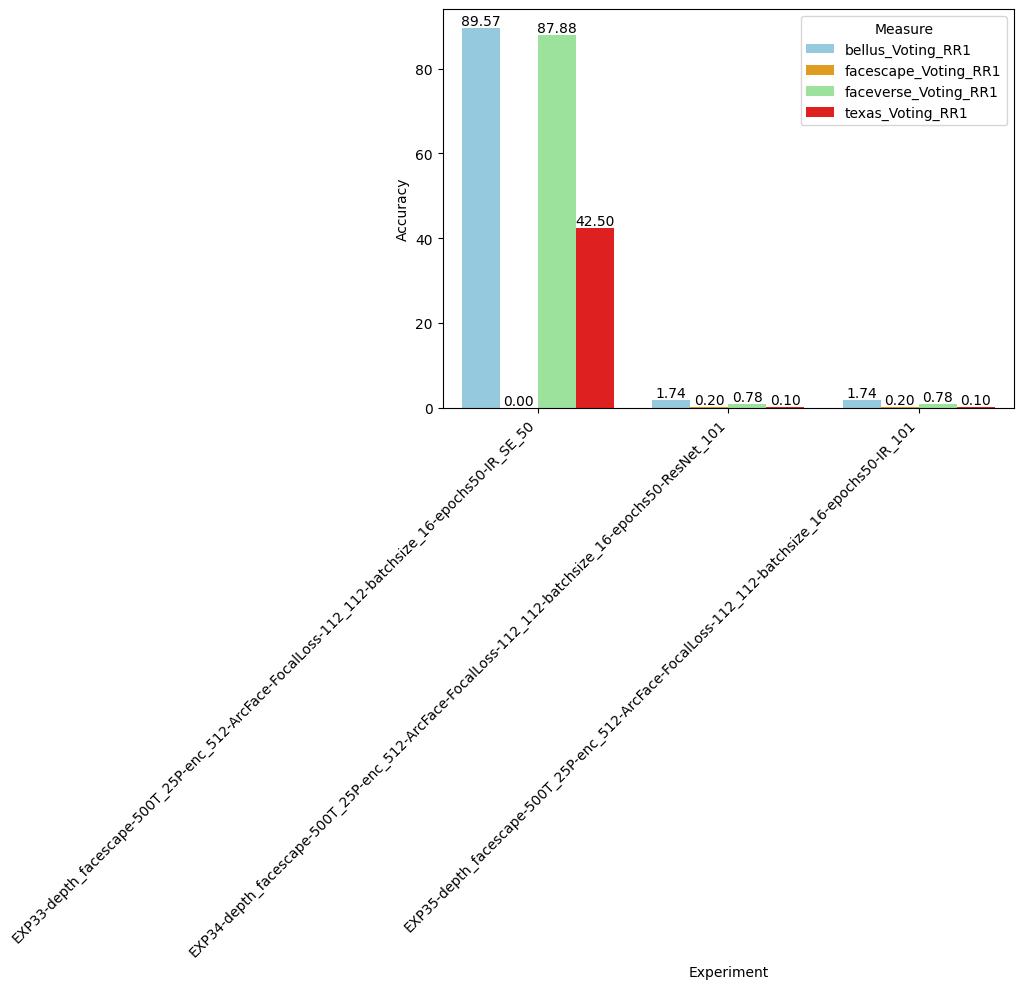

In [21]:
df_runs, run_configs = load_dataframe(directory)
df_selected = select_runs(df_runs, run_configs, ['EXP31-','EXP32-','EXP33-','EXP34-','EXP35-','EXP36-'])
analyze_accuracies(df_selected, run_configs, voting=False)
analyze_accuracies(df_selected, run_configs, voting=True)

### EXP [37-42] rgb_facescape-500T_25P-enc_512-ArcFace-FocalLoss-112_112-batchsize_16-epochs50-\<MODEL\>

Selected: 4 ['191019159014369042', '291381042239090087', '326530012412376213', '728041601083563116']


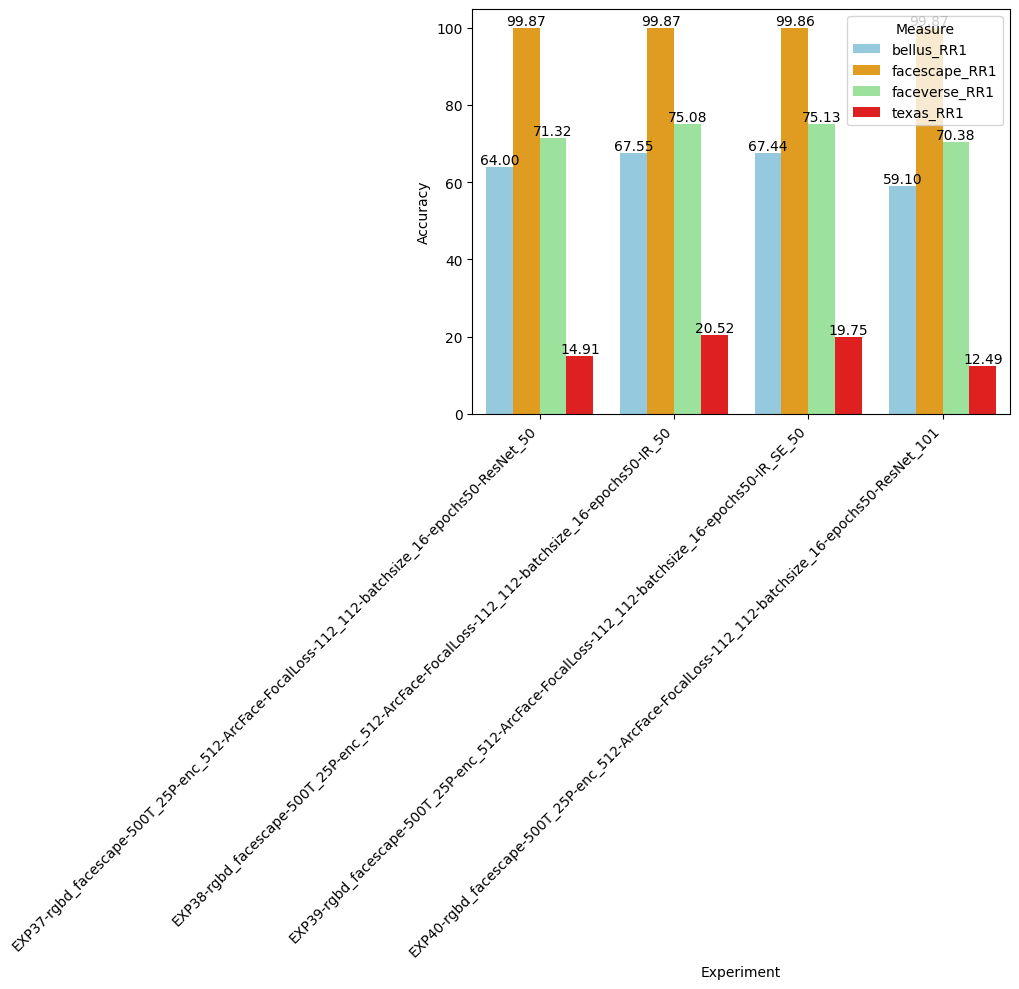

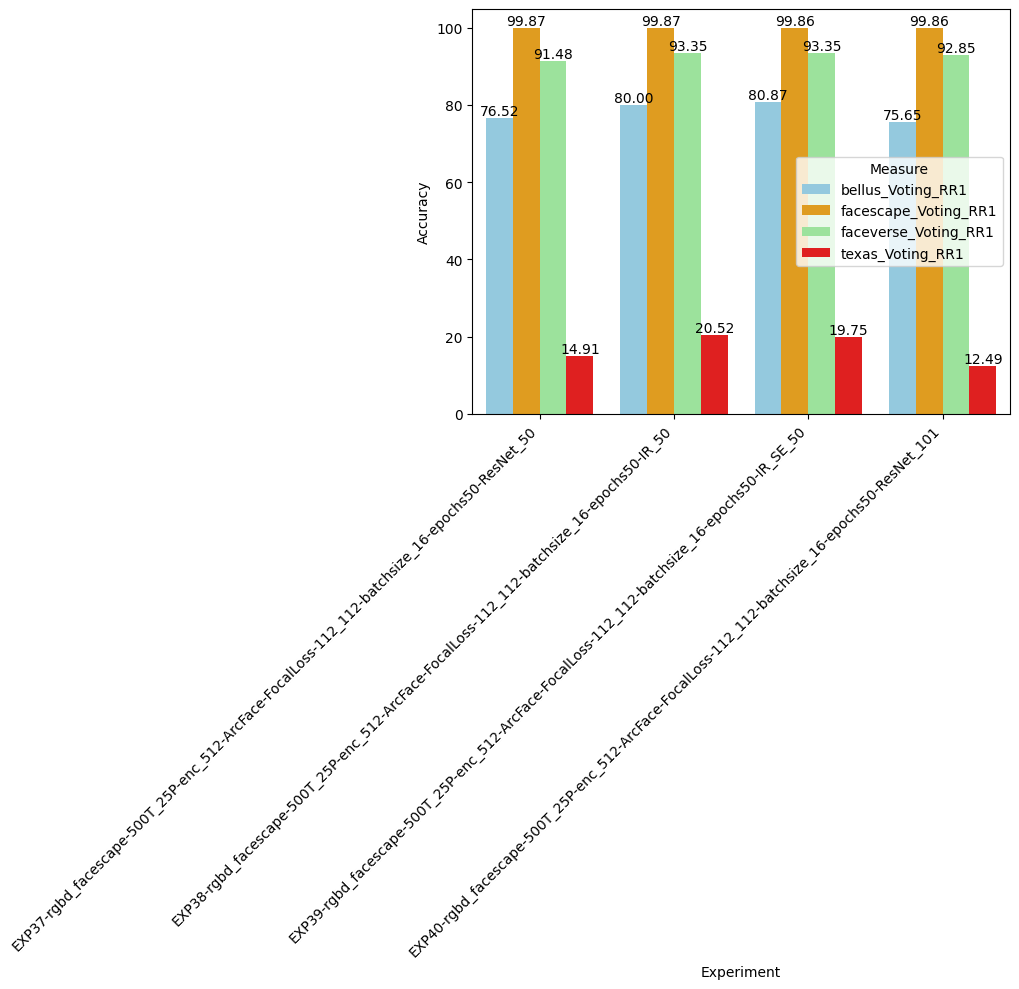

In [22]:
df_runs, run_configs = load_dataframe(directory)
df_selected = select_runs(df_runs, run_configs, ['EXP37-','EXP38-','EXP39-','EXP40-','EXP41-','EXP42-'])
analyze_accuracies(df_selected, run_configs, voting=False)
analyze_accuracies(df_selected, run_configs, voting=True)

### EXP [43-48] rgbd_bellus-45T_25P-enc_512-ArcFace-FocalLoss-224_244-batchsize_16-epochs50-\<MODEL\>

Selected: 0 []


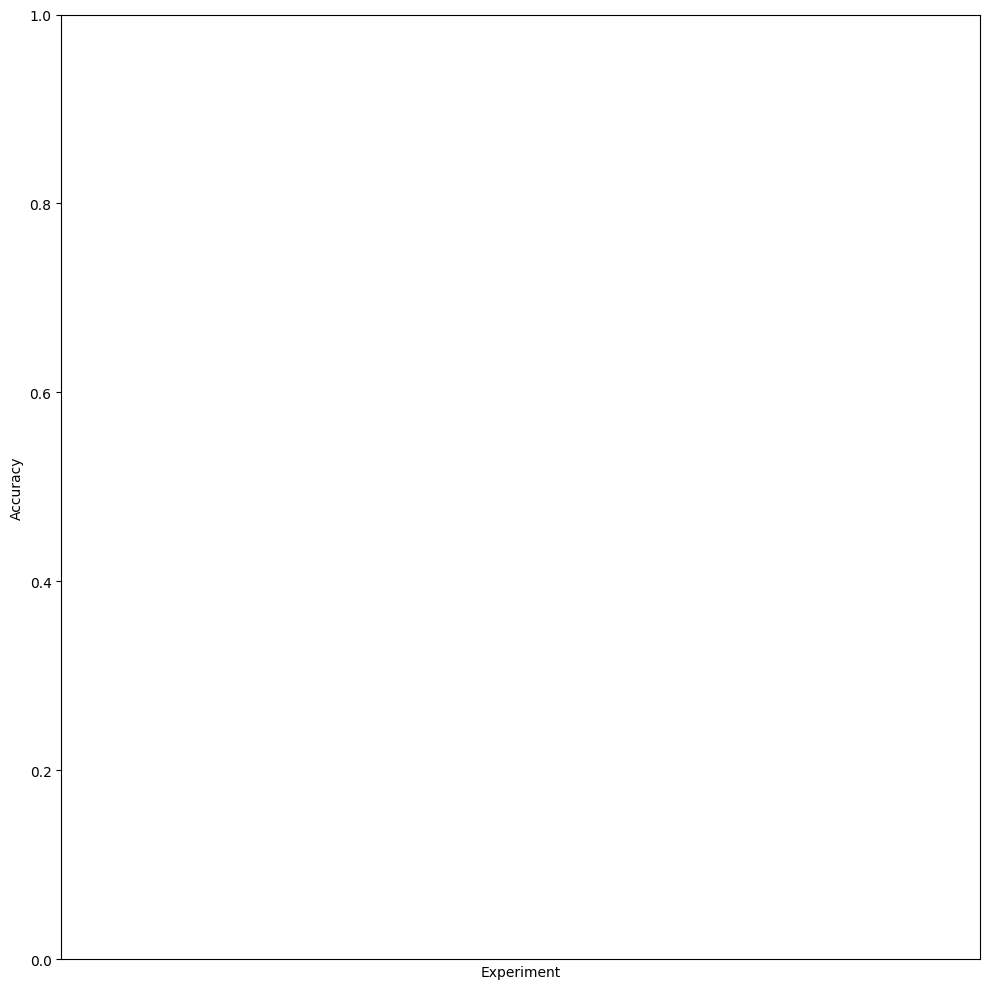

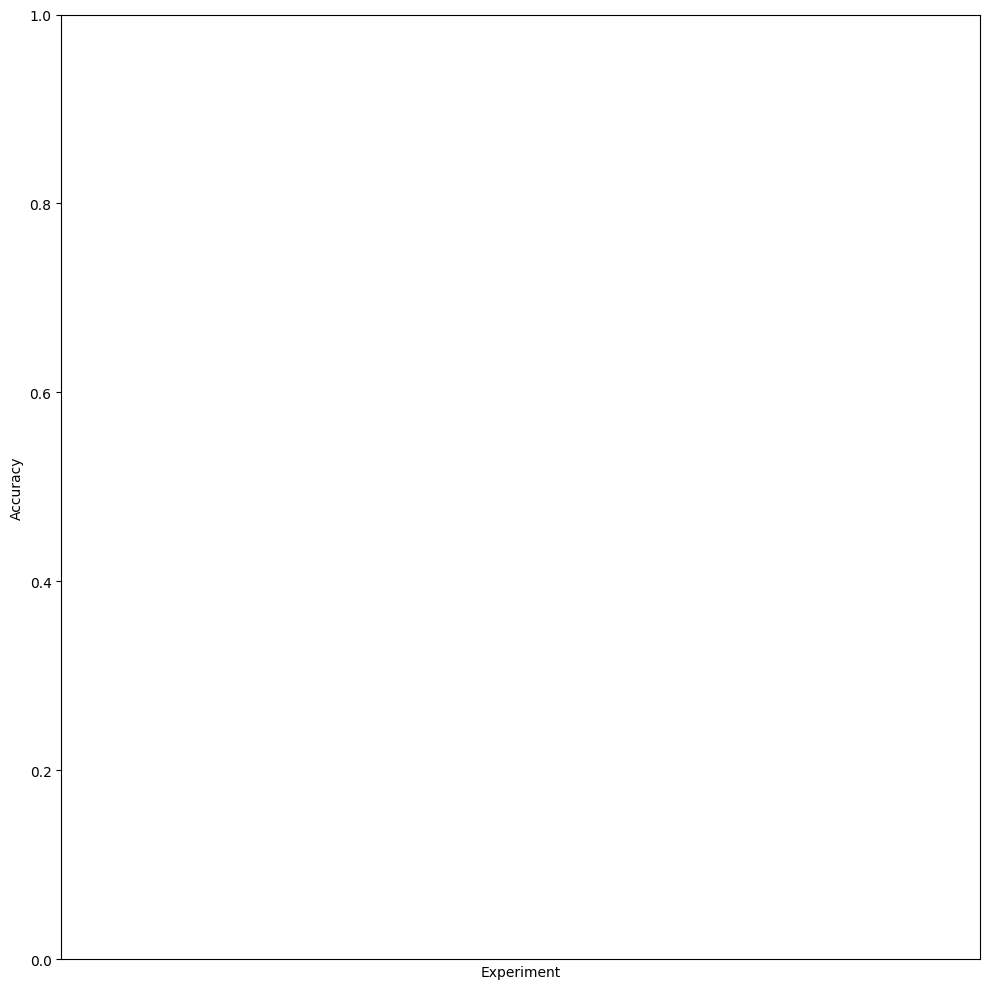

In [23]:
df_runs, run_configs = load_dataframe(directory)
df_selected = select_runs(df_runs, run_configs, ['EXP43-','EXP44-','EXP45-','EXP46-','EXP47-','EXP48-'])
analyze_accuracies(df_selected, run_configs, voting=False)
analyze_accuracies(df_selected, run_configs, voting=True)

### EXP [49-51] IR-50-Pretrained on MS and AsiaPrivate

Selected: 3 ['166643670449922767', '182152522377854970', '367576227080572980']


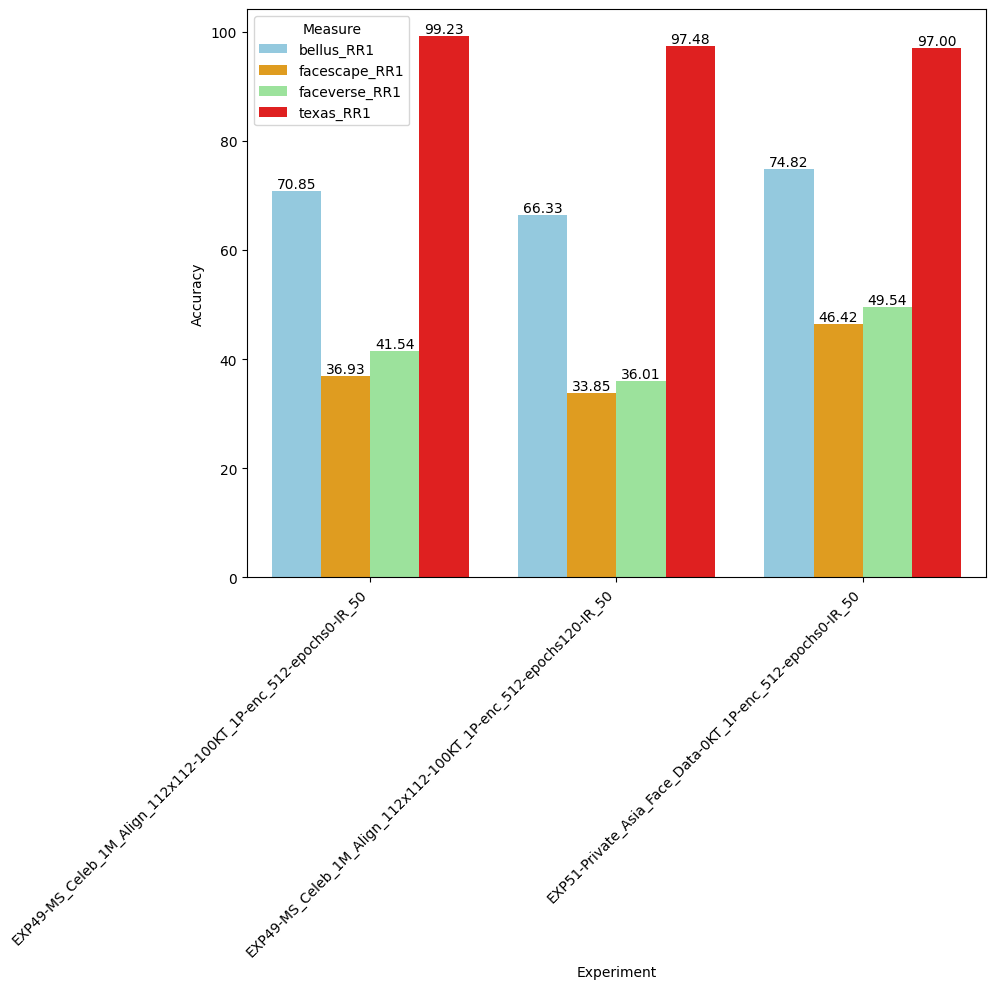

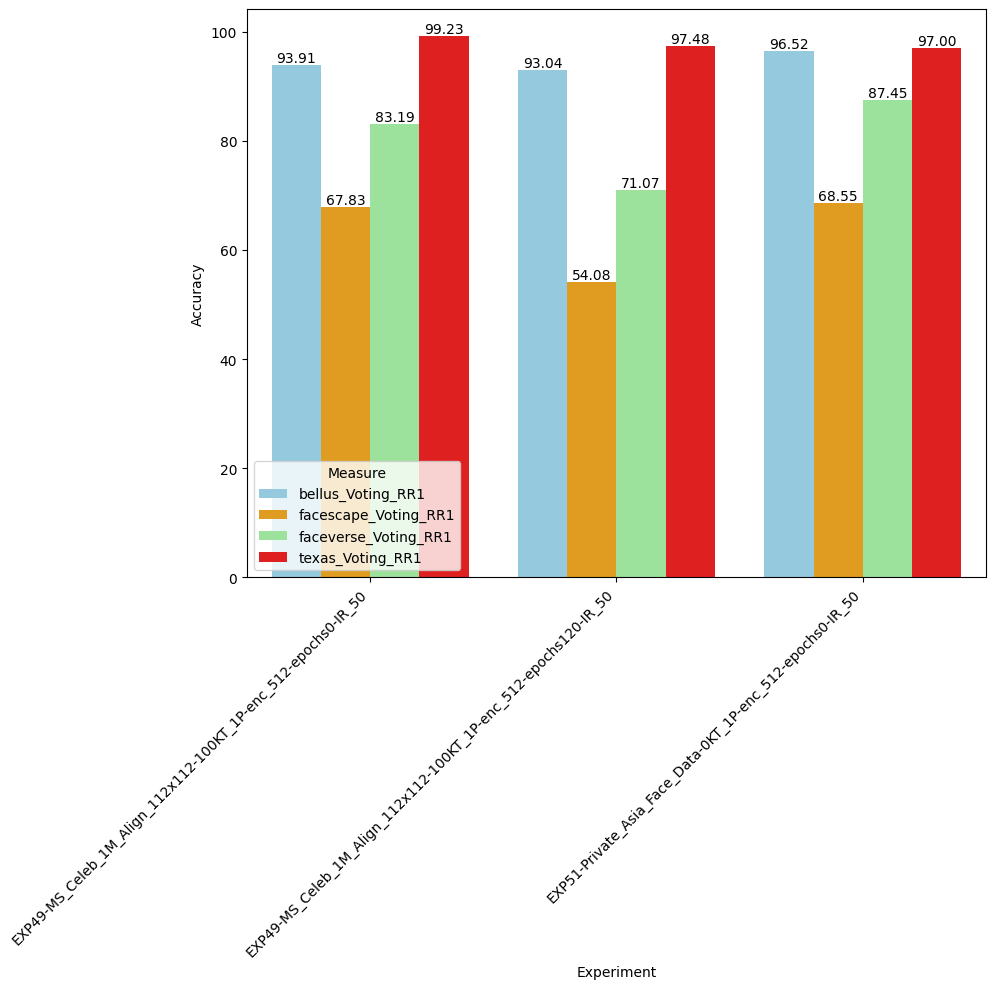

In [11]:
df_runs, run_configs = load_dataframe(directory)
df_selected = select_runs(df_runs, run_configs, ['EXP49-','EXP50-','EXP51-'])
analyze_accuracies(df_selected, run_configs, voting=False)
analyze_accuracies(df_selected, run_configs, voting=True)

### EXP [54-59] rgbd_bellus-45T_25P-enc_512-ArcFace-FocalLoss-112_112-batchsize_64-epochs50-\<MODEL\>

Selected: 0 []


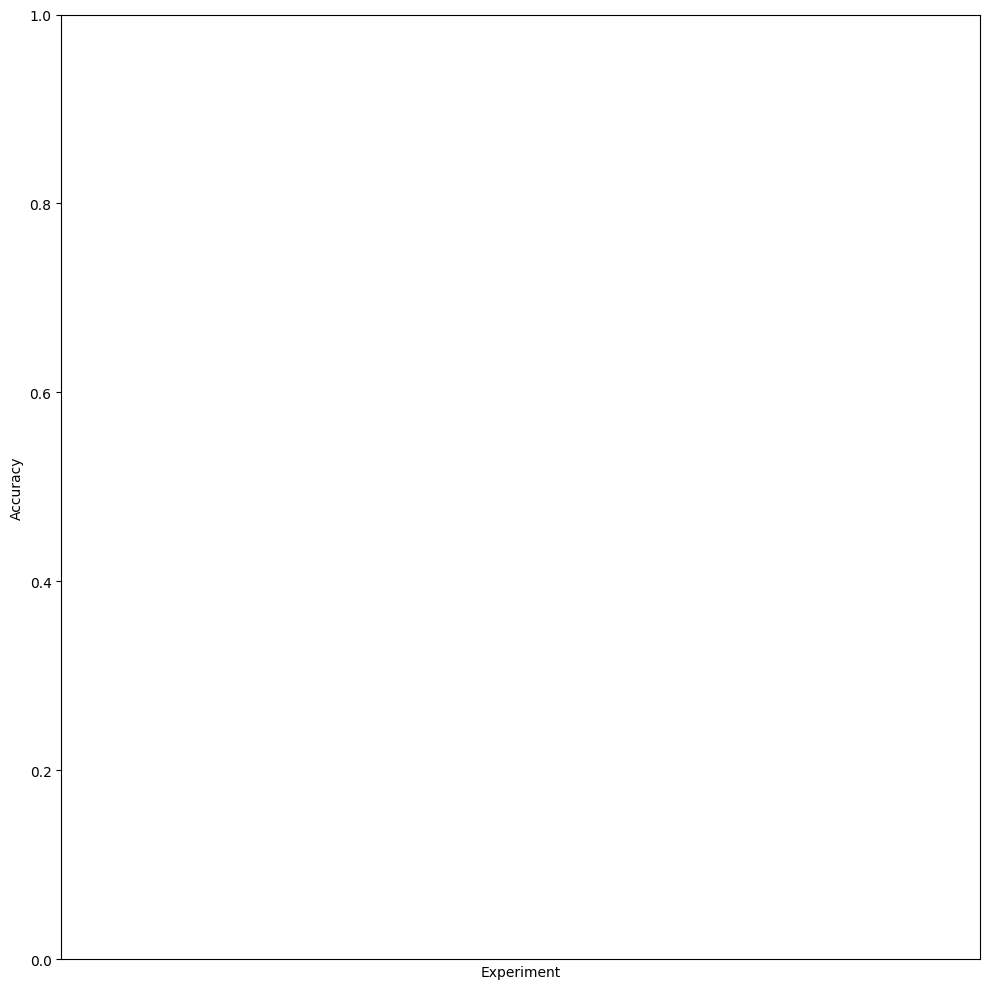

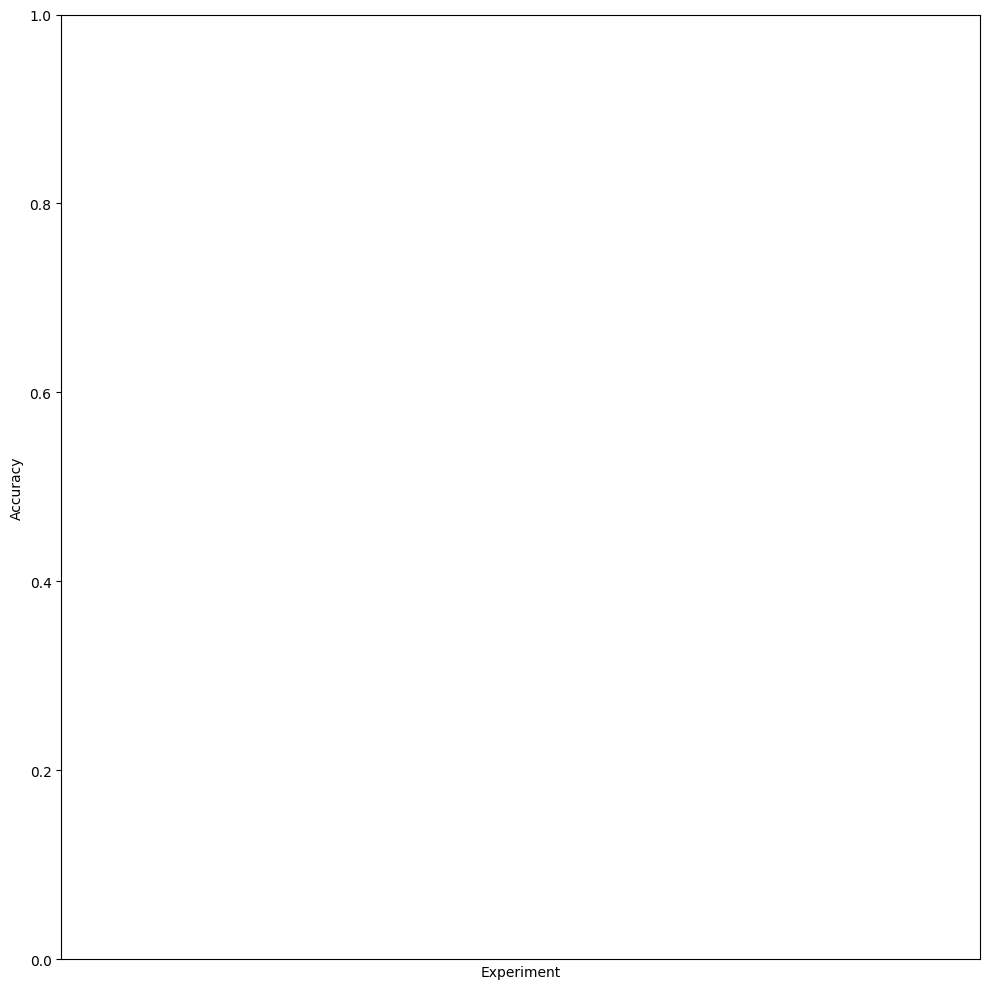

In [25]:
df_runs, run_configs = load_dataframe(directory)
df_selected = select_runs(df_runs, run_configs, ['EXP54-','EXP55-','EXP56-','EXP57-','EXP58-', 'EXP59-'])
analyze_accuracies(df_selected, run_configs, voting=False)
analyze_accuracies(df_selected, run_configs, voting=True)

### EXP [63-57] IR-50-Pretrained on MS and AsiaPrivate undistorted

Selected: 8 ['266575400434222983', '322148123534409772', '325978011602923062', '325978011602923062', '325978011602923062', '499229568889230827', '618050588810869860', '962789338795676195']


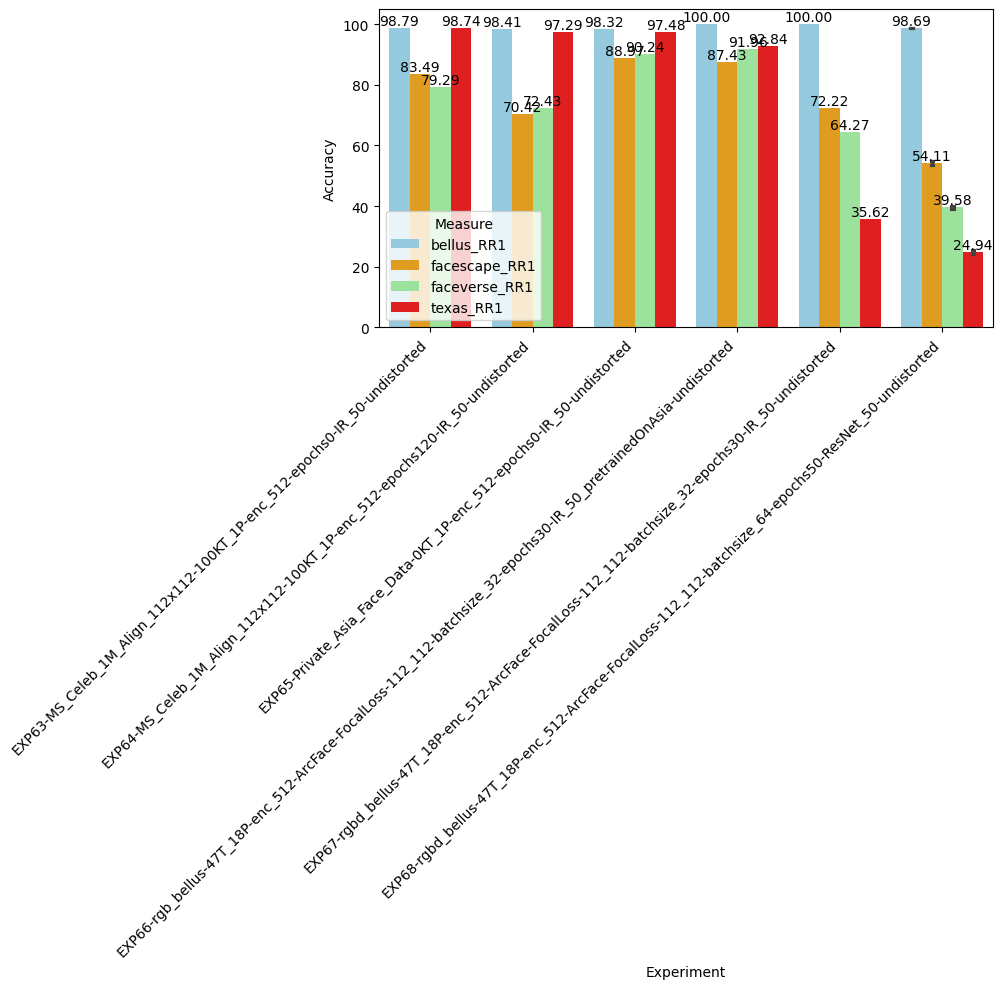

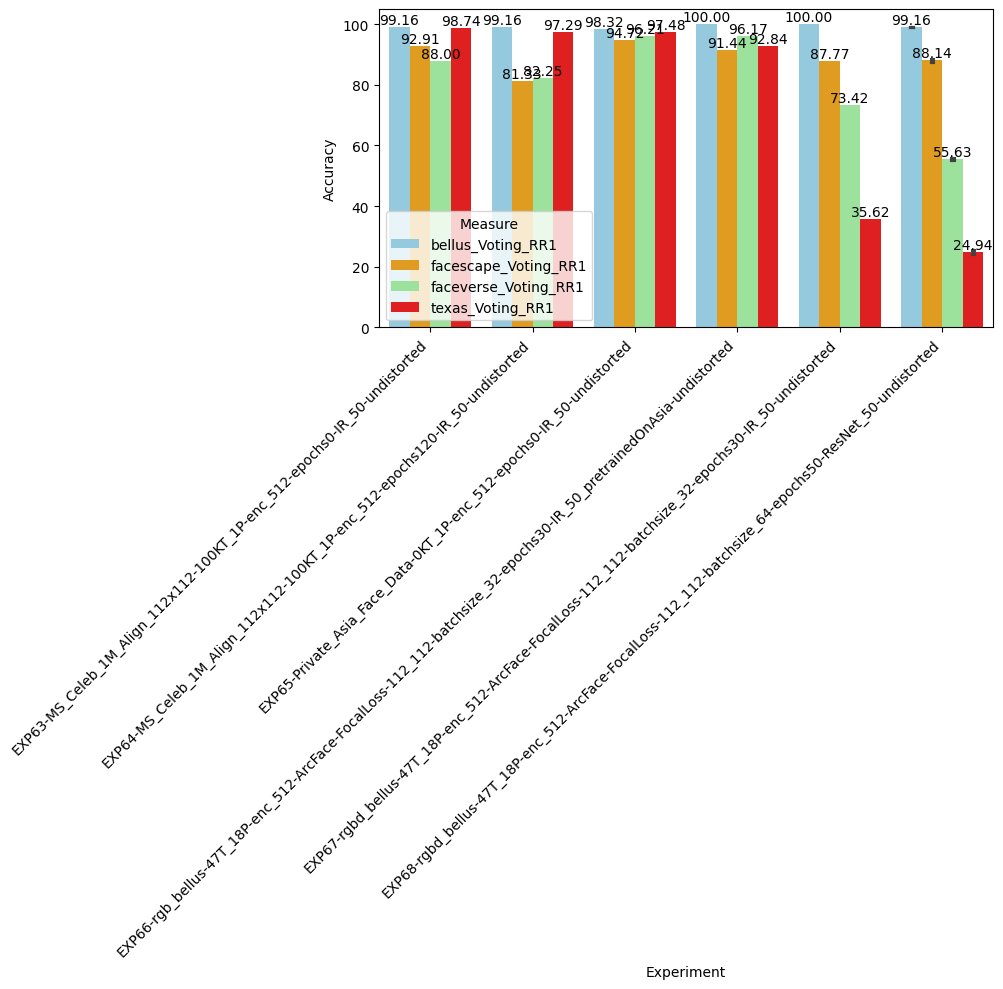

In [29]:
df_runs, run_configs = load_dataframe(directory)
df_selected = select_runs(df_runs, run_configs, ['EXP63-','EXP64-','EXP65-','EXP66-','EXP67-', 'EXP68-'])
analyze_accuracies(df_selected, run_configs, voting=False)
analyze_accuracies(df_selected, run_configs, voting=True)

### EXP [68-79] rgbd_bellus-45T_18P-enc_512-ArcFace-FocalLoss-112_112-batchsize_\<64-128\>-epochs50-\<MODEL\>-undistored

Selected: 17 ['281103519597288200', '281103519597288200', '281103519597288200', '307141597483709347', '307141597483709347', '307141597483709347', '325978011602923062', '325978011602923062', '325978011602923062', '727389981403576407', '727389981403576407', '820543159121493007', '866632454380967756', '915686142985997258', '927749406521887388', '959777342908963461', '968007903589141954']


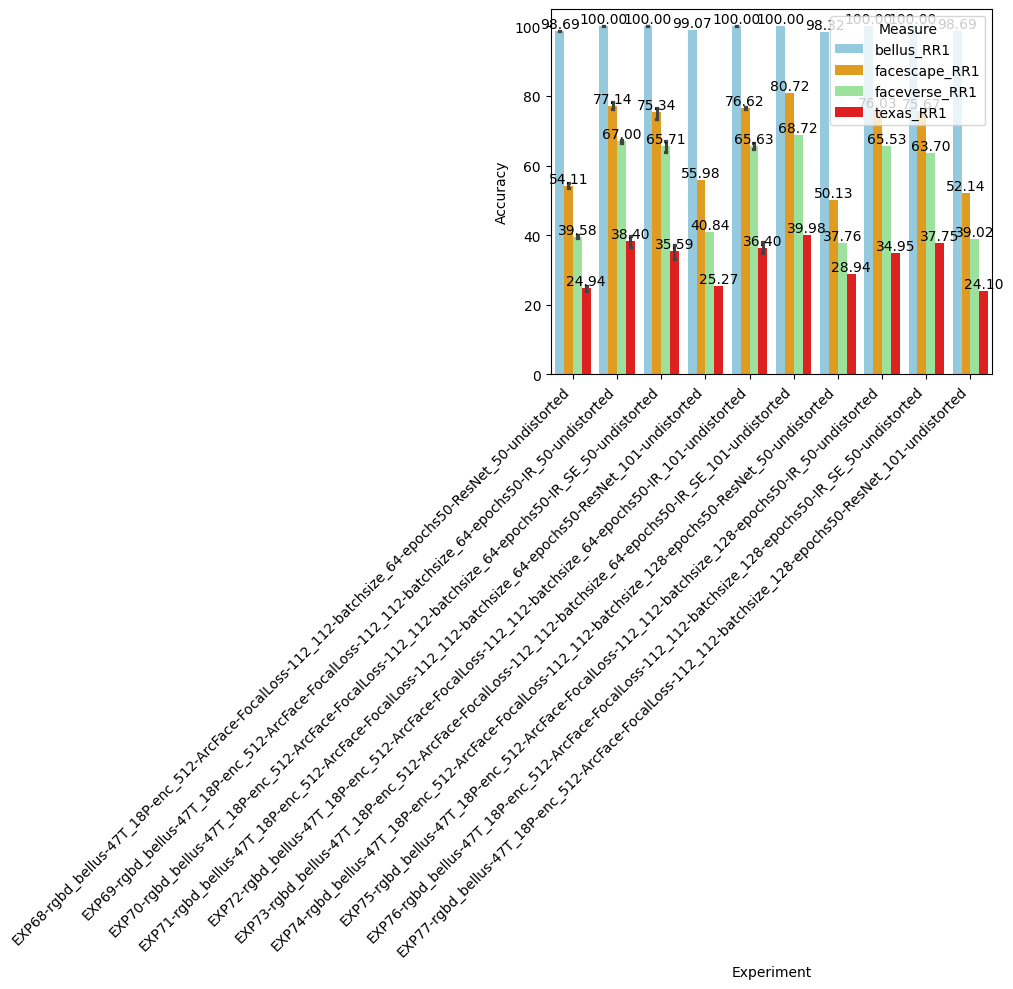

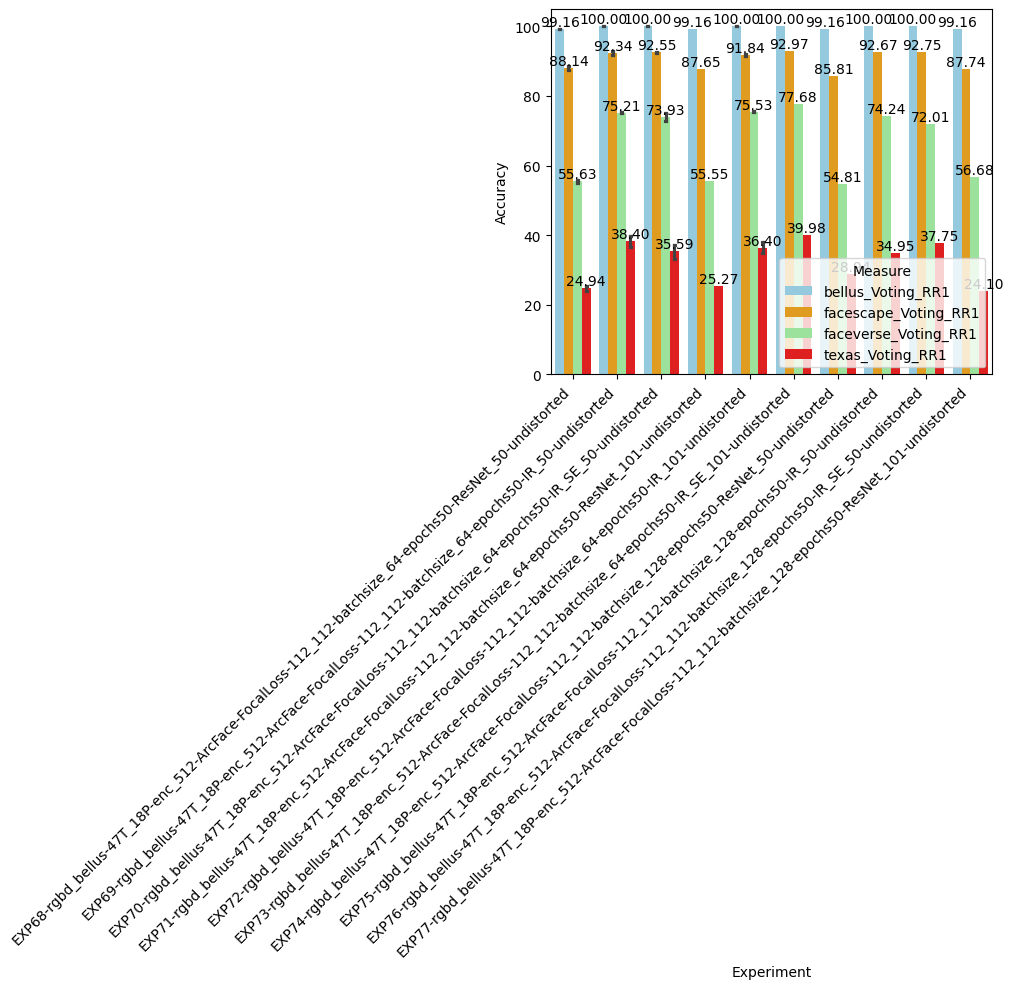

In [26]:
df_runs, run_configs = load_dataframe(directory)
df_selected = select_runs(df_runs, run_configs, ['EXP68-','EXP69-','EXP70-','EXP71-','EXP72-','EXP73-','EXP74-','EXP75-','EXP76-','EXP77-','EXP78-','EXP79-'])
analyze_accuracies(df_selected, run_configs, voting=False)
analyze_accuracies(df_selected, run_configs, voting=True)

### EXP [80-91] rgbd_facescape-500T_18P-enc_512-ArcFace-FocalLoss-112_112-batchsize_\<64-128\>-epochs50-\<MODEL\>

Selected: 0 []


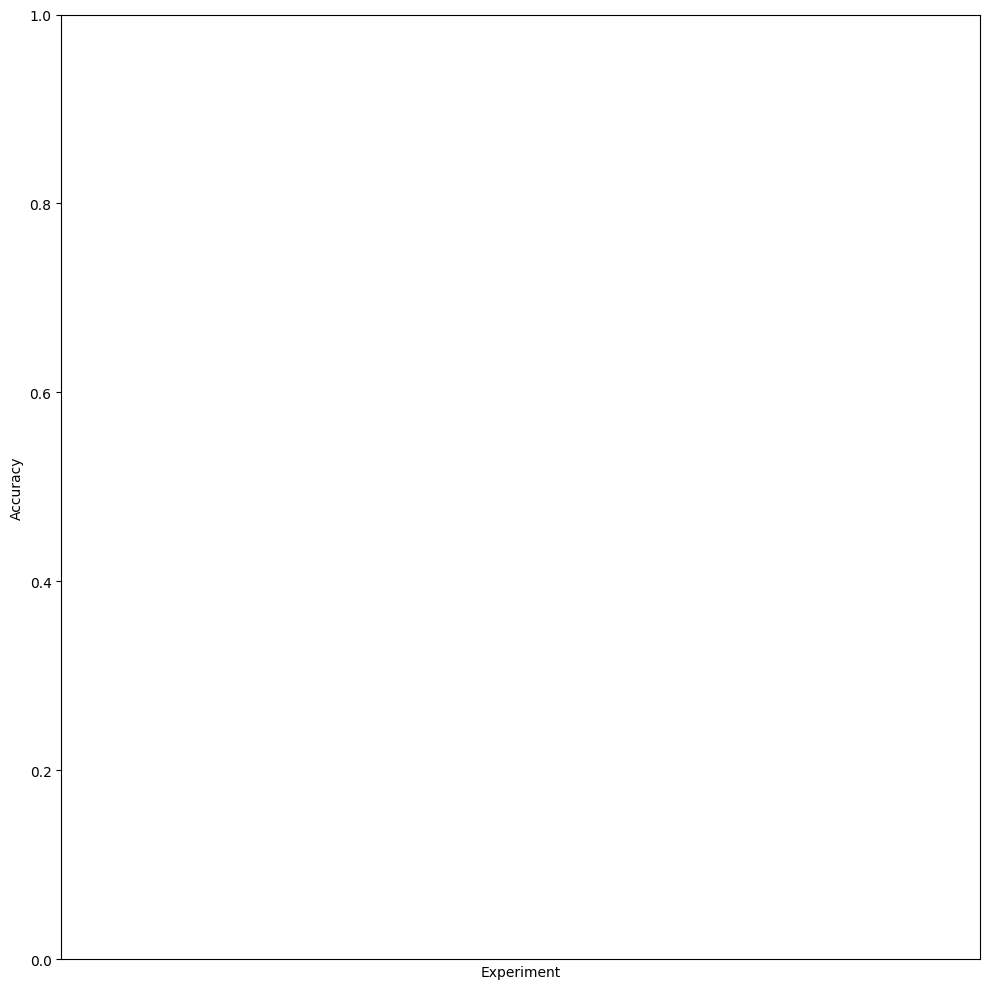

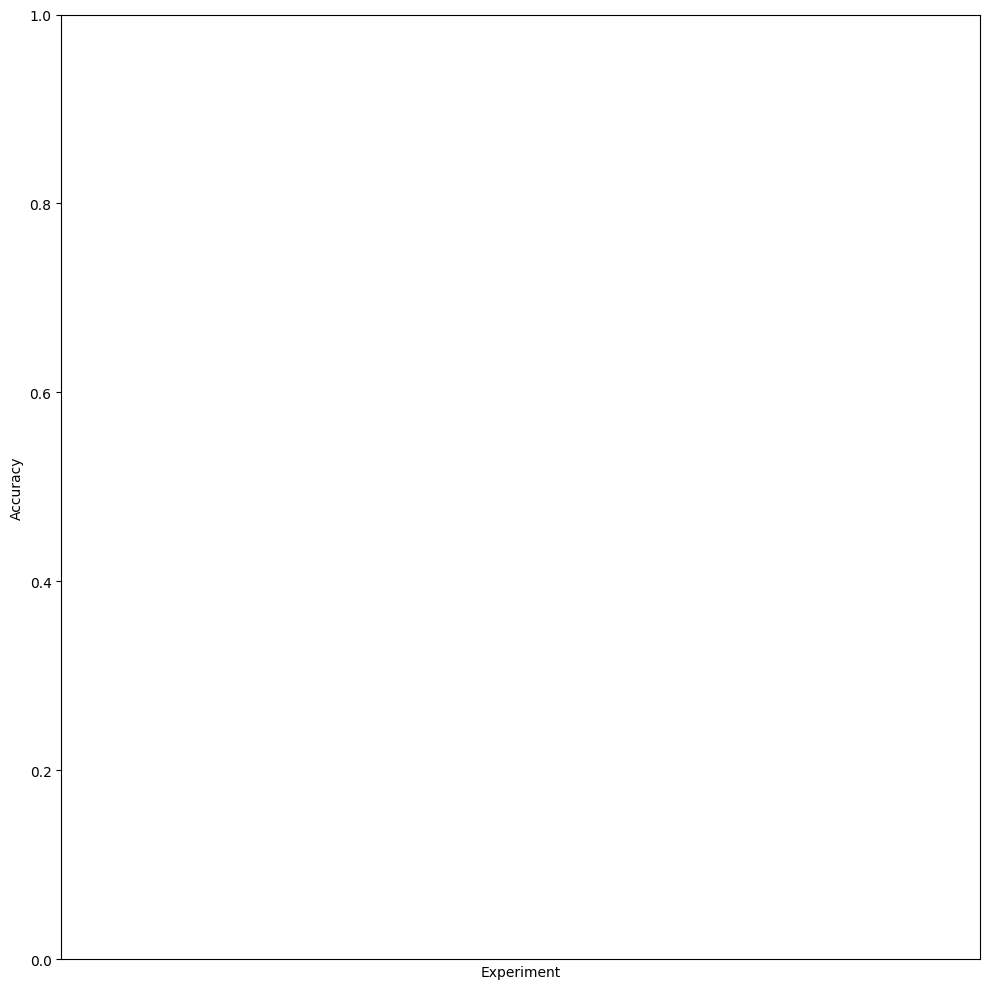

In [27]:
df_runs, run_configs = load_dataframe(directory)
df_selected = select_runs(df_runs, run_configs, ['EXP80-','EXP81-','EXP82-','EXP83-','EXP84-','EXP85-','EXP86-','EXP87-','EXP88-','EXP89-','EXP90-','EXP91-'])
analyze_accuracies(df_selected, run_configs, voting=False)
analyze_accuracies(df_selected, run_configs, voting=True)

## All Experiments

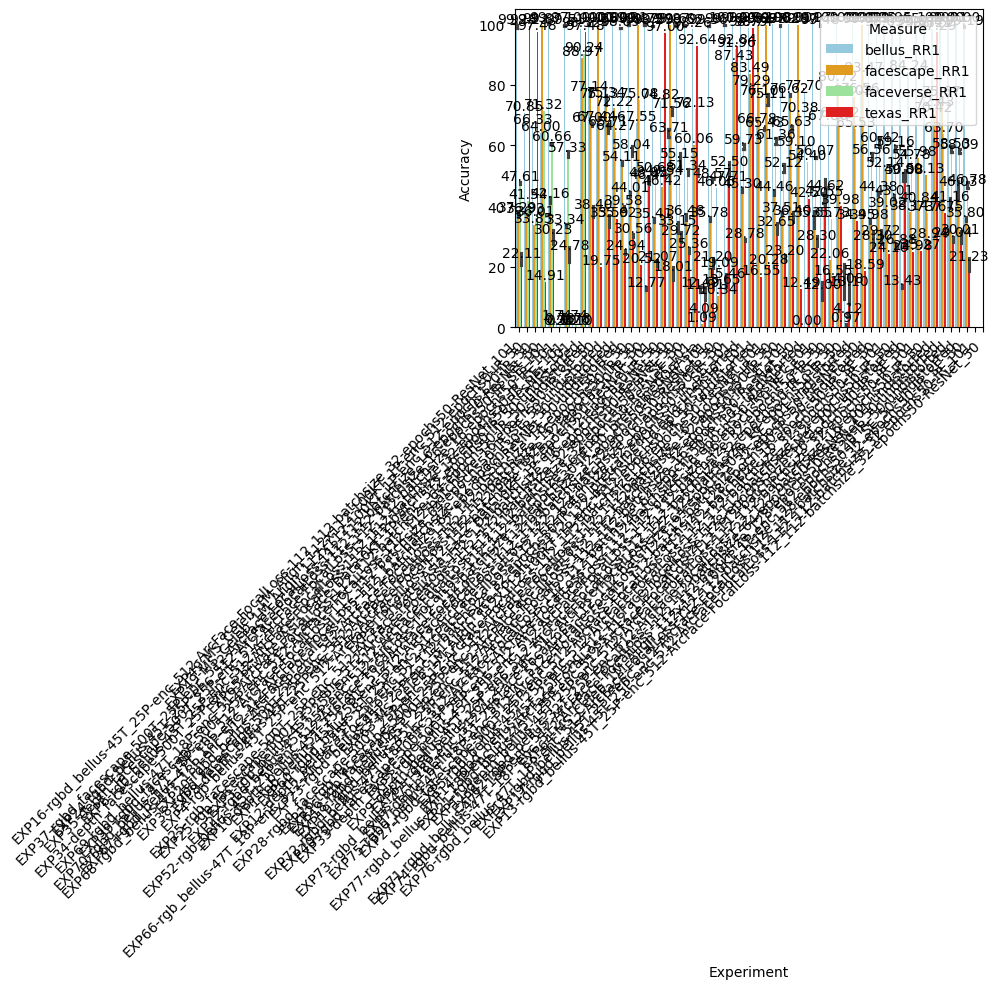

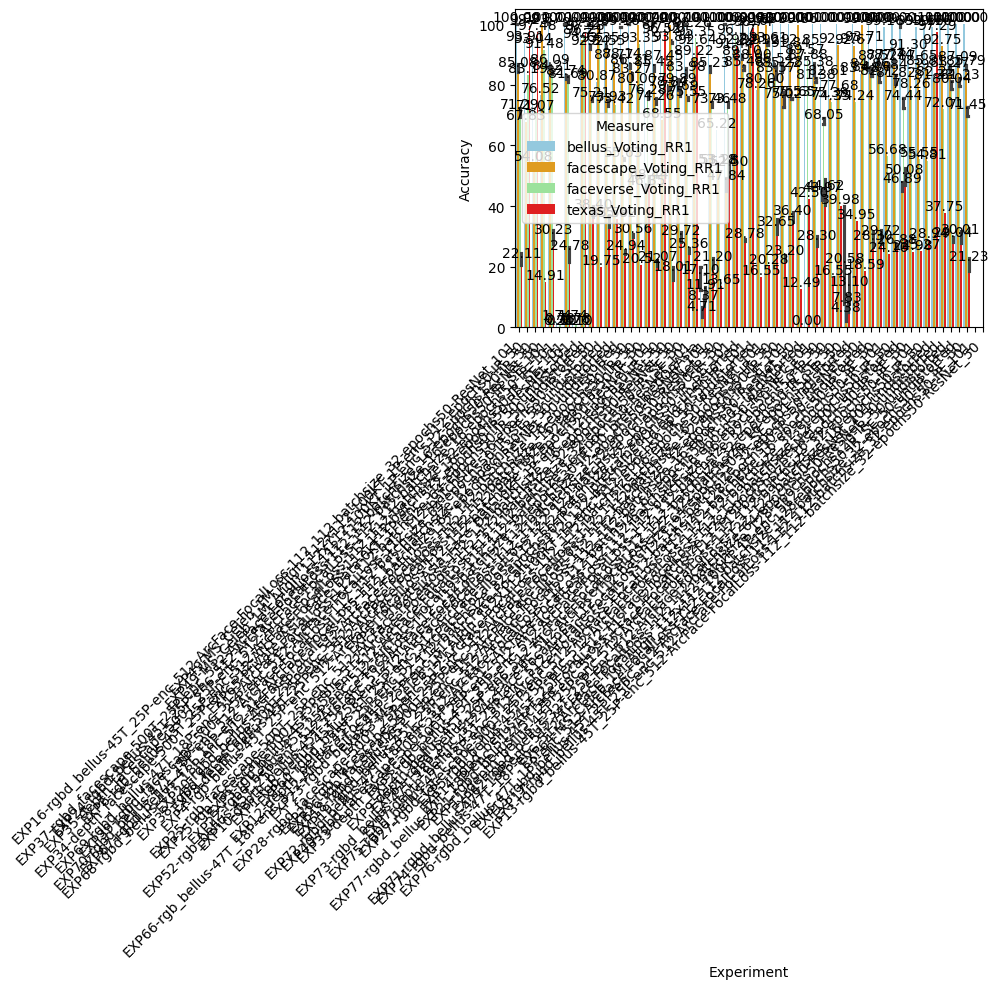

ValueError: array must not contain infs or NaNs

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


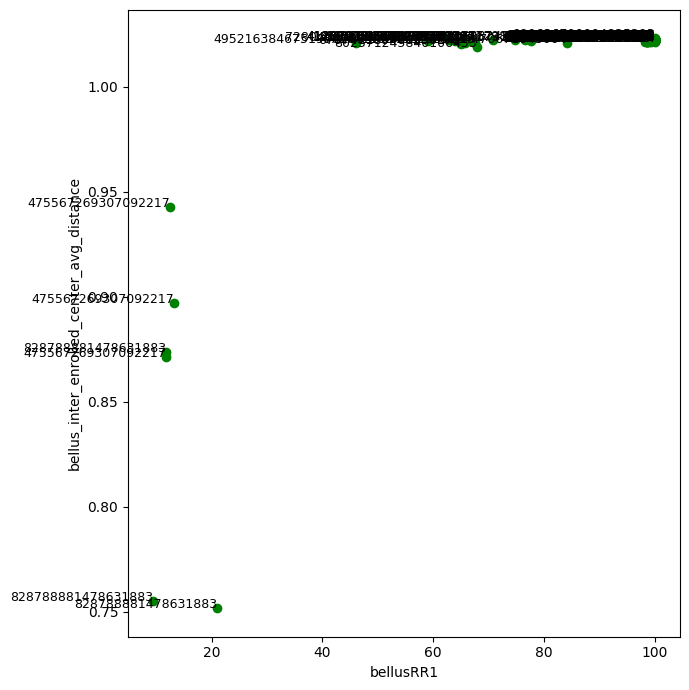

In [28]:
analyze_accuracies(df_runs, run_configs, voting=False)
analyze_accuracies(df_runs, run_configs, voting=True)
analyse_embedding(df_runs)

## EXP3:testmodels-RGB_11T_46V_SingleTrainSample-enc128-BigHead-BatchHardTripletMarginLoss-BATCHSIZE8-Epochs3

In [ ]:
combined_df = load_dataframe(directory)
analyze_accuracies_withtop5(combined_df, 'EXP3:testmodels-RGB_11T_57V_SingleTrainSample-enc128-BigHead-BatchHardTripletMarginLoss-BATCHSIZE8', 'rgb')

## EXP4:testmodels-DEPTH_11T_46V_SingleTrainSample-enc128-BigHead-BatchHardTripletMarginLoss-BATCHSIZE8

In [ ]:
combined_df = load_dataframe(directory)
analyze_accuracies_withtop5(combined_df, 'EXP4:testmodels-DEPTH_11T_57V_SingleTrainSample-enc128-BigHead-BatchHardTripletMarginLoss-BATCHSIZE8', 'depth')

## EXP5:testmodels-RGB_11T_46V_SingleTrainSample-enc128-BigHead-BatchHardTripletMarginLoss-BATCHSIZE8-OptimizedTripletSampler

In [ ]:
combined_df = load_dataframe(directory)
analyze_accuracies_withtop5(combined_df, 'EXP5:testmodels-RGB_11T_57V_SingleTrainSample-enc128-BigHead-BatchHardTripletMarginLoss-BATCHSIZE8-OptimizedTripletSampler', 'rgb')

## EXP6:testmodels-DEPTH_11T_46V_SingleTrainSample-enc128-BigHead-BatchHardTripletMarginLoss-BATCHSIZE8-OptimizedTripletSampler

In [ ]:
combined_df = load_dataframe(directory)
analyze_accuracies_withtop5(combined_df, 'EXP6:testmodels-DEPTH_11T_57V_SingleTrainSample-enc128-BigHead-BatchHardTripletMarginLoss-BATCHSIZE8-OptimizedTripletSampler', 'depth')

## EXP7:testmodels-Photos_11T_46V_SingleTrainSample-enc128-BigHead-TripletLoss-BATCHSIZE8

In [ ]:
combined_df = load_dataframe(directory)
analyze_accuracies_withtop5(combined_df, 'EXP7:testmodels-Photos_11T_57V_SingleTrainSample-enc128-BigHead-TripletLoss-BATCHSIZE8', 'rgb')

## EXP8:testmodels-Photos_11T_46V_SingleTrainSample-enc128-BigHead-BatchHardTripletLoss-BATCHSIZE8

In [ ]:
combined_df = load_dataframe(directory)
analyze_accuracies_withtop5(combined_df, 'EXP8:testmodels-Photos_11T_57V_SingleTrainSample-enc128-BigHead-BatchHardTripletLoss-BATCHSIZE8', 'rgb')

## EXP9:RGB_15T_51V_SingleTrainSample-enc128-BigHead-BatchHardTripletLoss-BATCHSIZE8

In [ ]:
combined_df = load_dataframe(directory)
analyze_accuracies_withtop5(combined_df, 'EXP9:RGB_15T_51V_SingleTrainSample-enc128-BigHead-BatchHardTripletLoss-BATCHSIZE8', 'rgb')

## EXP10:Depth_15T_51V_SingleTrainSample-enc128-BigHead-BatchHardTripletLoss-BATCHSIZE8

In [ ]:
combined_df = load_dataframe(directory)
analyze_accuracies_withtop5(combined_df, 'EXP10:DEPTH_15T_51V_SingleTrainSample-enc128-BigHead-BatchHardTripletLoss-BATCHSIZE8', 'depth')

## EXP11:RGB_34T_92V_SingleTrainSample-enc128-BigHead-BatchHardTripletLoss-BATCHSIZE8

In [ ]:
combined_df = load_dataframe(directory)
analyze_accuracies_withtop5(combined_df, 'EXP11:RGB_34T_92V_SingleTrainSample-enc128-BigHead-BatchHardTripletLoss-BATCHSIZE8', 'rgb')

## EXP12:DEPTH_34T_92V_SingleTrainSample-enc128-BigHead-BatchHardTripletLoss-BATCHSIZE8

In [ ]:
combined_df = load_dataframe(directory)
analyze_accuracies_withtop5(combined_df, 'EXP12:DEPTH_34T_92V_SingleTrainSample-enc128-BigHead-BatchHardTripletLoss-BATCHSIZE8', 'depth')

## Analye Parametersize correlation:

In [ ]:
num_params = {"VGG16Face": 224696256,
        "VGG16Face_IMAGENET1K_V1": 224696256,
        "ResNet18": 1833152,
        "ResNet18_IMAGENET1K_V1": 1833152,
        "ResNet34": 21941312,
        "ResNet34_IMAGENET1K_V1": 21941312,
        "ResNet50": 32425280,
        "ResNet50_IMAGENET1K_V1": 32425280,
        "ConvNeXtTiny": 29196640,
        "ConvNeXtTiny_IMAGENET1K_V1": 29196640,
        "EfficientnetV2Small": 23784784,
        "EfficientnetV2Small_IMAGENET1K_V1": 23784784,
        "Squeezenet": 182654784,
        "Squeezenet_IMAGENET1K_V1": 182654784,
        "Shufflenet": 108736996,
        "Shufflenet_IMAGENET1K_V1": 108736996,
        "MobileNetV3":1739424,
        "MobileNetV3_IMAGENET1K_V1": 1739424,
        "WideResNet50": 68277312,
        "WideResNet50_IMAGENET1K_V1": 68277312,
        "WideResNet101": 133754944,
        "WideResNet101_IMAGENET1K_V1": 133754944,
        "GhostFaceNetV1": 2843565,
        "GhostFaceNetV2": 3817965}

dictlist = []
models = []
for key, value in num_params.items():
    temp = [key,value]
    dictlist.append(value)
    models.append(key)
models = pd.DataFrame(models)



combined_df = load_dataframe(directory)
grouped = combined_df.groupby('model_name')['accuracy_list'].max()
#print(grouped)

# Now, you want to match the model names with the 'num_params' dictionary and get a list of tuples.
x = []
y = []
labels = []
for model_name, max_accuracy in grouped.items():
    # Look up the number of parameters in 'num_params' dictionary using the model name.
    num_parameters = num_params.get(model_name)
    if num_parameters is not None:
        # If the model name exists in the 'num_params' dictionary, append the tuple to the result list.
        y.append(max_accuracy[0])
        x.append(num_parameters)
        labels.append(model_name)

plt.figure(figsize=(15, 6))
coefficients = np.polyfit(x, y, 1)
poly = np.poly1d(coefficients)
val_linspace = np.linspace(min(x), max(x), len(x))
plt.scatter(x, y, color='green')
plt.plot(val_linspace, poly(val_linspace), color='blue', linestyle='dashed', linewidth=2)
for i, label in enumerate(labels):
    plt.text(x[i], y[i], label, fontsize=9, ha='right')
plt.xlabel('num_params')
plt.ylabel('accuracy')
plt.tight_layout()
plt.show()
correlation_coefficient, _ = pearsonr(x, y)
print(f"Correlation coefficient: {correlation_coefficient:.3f}")

## EXP13:RGBD_34T_92V_SingleTrainSample-enc128-BigHead-BatchHardTripletLoss-BATCHSIZE8

In [ ]:
combined_df = load_dataframe(directory)
analyze_accuracies_withtop5(combined_df, 'EXP13:RGBD_34T_92V_SingleTrainSample-enc128-BigHead-BatchHardTripletLoss-BATCHSIZE8', 'rgbd')

## EXP14:Photos_34T_92V_SingleTrainSample-enc128-BigHead-BatchHardTripletLoss-BATCHSIZE8

In [ ]:
combined_df = load_dataframe(directory)
analyze_accuracies_withtop5(combined_df, 'EXP14:Photos_34T_92V_SingleTrainSample-enc128-BigHead-BatchHardTripletLoss-BATCHSIZE8', 'rgb')